## ${\color{lime}{\text{Final Project - Reinforcement Learning (RL)}}}$

#### ${\color{orange}{\text{Ehud Avrahami : 215989815}}}$
#### ${\color{orange}{\text{Matan Ginzburg : 215717067}}}$


## ${\color{lime}{\text{Introduction}}}$

In this project we are going to compare between two algorithms: **Deep Q-Network** and **Actor Critic** in the gymnasium Lunar-Lander v3 environment.  

Lunar-Lander gym environment: rocket trajectory optimization problem, we want the spaceship to land safely and use as little fuel as possible.  
There are 4 possible actions in each state:  
(0): do nothing  
(1): fire left orientation engine  
(2): fire main engine  
(3): fire right orientation engine  
The observation space is 8-dimensional vector : coordinates of the lander in (x,y), its linear velocities in (x,y), angle, angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.   
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.  

The episodes are considered successful if the reward is 200 or higher.  

This is the report of the findings of our project in Lunar-Lander v3.

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
import random
from collections import deque
from torch.optim.lr_scheduler import StepLR


g = torch.Generator()
g.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env=gym.make('LunarLander-v3')

print(env.action_space)
observation, info = env.reset()
next_observation, reward, terminated, truncated, info = env.step(0)
print(observation.shape[0])
env.close()

Discrete(4)
8


In [4]:
def plot_rewards(episodes, train_rewards, val_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(range(episodes-1), train_rewards, label='Training reward')
    plt.plot(range(episodes-1), val_rewards, label='Validation reward')
    plt.axhline(y=200, color='red', linestyle='--', label='Target reward (200)')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()


In [ ]:
def plot_time_array(episodes, time_array):
    plt.figure(figsize=(10, 5))
    plt.plot(range(episodes-1), time_array, label='training time')
    plt.xlabel('Episodes')
    plt.ylabel('time (seconds)')
    plt.legend()
    plt.show()


# ${\color{lime}{\text{Deep Q-Network }}}$

### ${\color{cyan}{\text{Theoretical material and algorithm}}}$

DQN is a similar algorithm to Q-Learning (another algorithm that we learned) but unlike Q-Learning, which is not that good for complex problems or many possible situations, \
DQN excel in those kind of problems, DQN overcomes this challenge with Neural Networks.  
We want to learn the optimal policy by estimating the Q-value function(which gives us the rewards of each action in a certain situation) and to find the actions that give us the highest rewards over time.

##### What it consists of:  
**Our Policy net** - the main neural network that we work on, it approximates our Q-Value function $Q(s,a,w)$  
**Experience replay** - mini batches of transition $(s,a,r,s')$  
**Target net** - second neural network, used to compute Q-learning targets $Q(s,a,w^-)$, built with fixed parameters that we update after a certain number of steps.  
**Updating the network**: we want to optimize the MSE loss between the predicted Q-values and the target Q-values:  
$$L_i(w_i) = E[(r+\gamma \cdot max_{a'} Q(s',a',w^- _i) - Q(s,a,w_i))^2]$$
($w^-$ - weights of the target net (fixed weights) , $w$ - weights of the policy net.)

### The Training Process:  
**Initialization** - initialize the reply memory, policy and target network.  
**Exploration and Exploitation** - we will use the $\epsilon$-greedy policy to explore and exploit,  
with probability $\epsilon$ select random action otherwise take the action with highest Q-Value (greedy).  
**Collecting Experience** - Experience with the environment and store $(s,a,r,s')$ in the reply memory.  
It helps stabilize the process and during training the mini batches of experience are sampled randomly which breaks the correlation between consecutive experiences which improves generalization.  
**Training** - We will sample a mini-batch from the replay memory and compute the target Q-values (using the target network), then we update the main network by minimizing the loss function.  
**Updating Target Network** - Periodically copy the weights of the main network to the target network.  
**Decay $\epsilon$** - We will gradually decrease $\epsilon$ over time to shift from exploration to exploitation.   
 
The policy net is the network that we are going to train on, we will update the policy net by minimizing the loss function.  
while the target net will be updated after a certain number of steps(periodically), and we are going to copy the weights from the main net to the target, this way we ensure stability with the way we compute target Q-values. \\ \\

### ${\color{cyan}{\text{Q-Learning}}}$

As we said before, DQN is similar to Q-learning so let us remind ourselves what Q-learning is.  
The idea : we create a Q-table which stores Q-values, each Q-value estimates how good it is to take a specific action in a given state in terms of expected future rewards.  
Then we learn and update the table by the feedback we receive.  
We update the Q-values over time using the Bellman equation and Temporal Difference (TD) update rule.   
$$Q(s,a) \leftarrow Q(s,a) + \alpha ( r+ \gamma \max_{a'}Q(s',a') - Q(s,a) )$$

How do we get to the Bellman equation?  
policy : $\sum _a \pi(s,a)$ gives us all possible action  
Reward (From time $t$ going forward, giving less importance to the future rewards with $\gamma$) :
$$R_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3}+... = 
r_{t+1} + \gamma(r_{t+2} + \gamma r_{t+3}+...) = r_{t+1}+ \gamma R_{t+1} $$ 
Value function (the expected overall rewards from state $s$) :
$$V^{\pi} (s) = \mathbb{E}[R_t|s_t = s]$$ 
Action value function (the expected overall rewards from action $a$  from state $s$) : 
$$Q^{\pi} (s,a) = \mathbb{E}[R_t|s_t = s,a_t=a]$$  

Let's play with this a bit:  
We will define the expected immediate reward $r_{t+1}$ for going from state $s$ to state $s'$ through action $a$ as: 
$$R^a _ {ss'} = \mathbb{E}[r_{t+1}|s_t = s,a_t=a,s_{t+1} = s']$$  
and we will define the transition probability for going from state $s$ to state $s'$ through action $a$ as: 
$$ P^a _ {ss'} = P(s_{t+1} = s' | s_t=s, a_t=a) $$

$$Q^{\pi} (s,a) = \mathbb{E}[R_t|s_t = s,a_t=a] = \mathbb{E}[r_{t+1}+ \gamma R_{t+1}|s_t = s,a_t=a] = 
\mathbb{E}[r_{t+1}|s_t = s,a_t = a] + \gamma \mathbb{E}[R_{t+1}|s_t = s,a_t=a]$$ 
$$ \mathbb{E}[r_{t+1}|s_t = s,a_t = a] = \sum_{s' \in S} P^a _ {ss'} R^a _ {ss'} $$
$\sum_{s'} P^a _ {ss'} R^a _ {ss'}$ gives us the reward of the action from s to $s'$  
($P^a _ {ss'}$ - probability of landing in $s'$ from $s$ if $a$ is taken , $R^a _ {ss'}$ - reward for going from $s$ to $s'$ through $a$,  
$S$  represents all possible states through action $a$ from state $s$ ) 

$$\gamma \mathbb{E}[R_{t+1}|s_t = s,a_t=a]=\gamma \sum_{s' \in S} P^a _ {ss'} V^{\pi}(s')$$
The same idea as the equation before, but this time we have $V^{\pi} (s')$ which is the expected total reward we can get starting from that state (with policy $\pi$
) 
$$ Q^{\pi}(s,a) = \sum_{s' \in S} P^a _ {ss'} (R^a _ {ss'}+\gamma V^{\pi}(s')) $$

Now this form of the Q-value handles stochastic environments(whenever we take an action and we don't always end up in the same next state), 
we will now write it in a deterministic environment - whenever we take an action we will always end up in the same next state and receive the same reward. 
(now probability to land in $s'$ is 1 and all other probabilities are 0)    
We can rewrite the Q-value function: 
$$ Q^{\pi} (s,a) = R^a _ {ss'} + \gamma V^{\pi}(s') $$
to simplify: 
$$ Q^{\pi} (s,a) = r(s,a) + \gamma V^{\pi}(s') $$
Since we use the $\epsilon$-greedy policy we can have the relation between the state value and the action value function:
$$ V(s) = \max_a Q(s,a) $$ 
Final equation:
$$ Q(s,a) = r(s,a) + \gamma \max_{a'} Q(s',a') $$
This is the Bellman Optimality Equation which  we use in DQN as well.

About the deterministic and stochastic part:  
Even tough Q-learning and DQN are designed to handle stochastic environments they also work in a deterministic environments,  
both Q-learning and DQN learn the expected value (we update Q-values using samples, over time the samples average out the randomness and so the Q-values converges to the expected value.)  
In a deterministic environment they converge faster because the environment behaves predictably.

Temporal Difference(TD) :  
We want to update the Q-values by comparing the current state and action value estimate with a new estimate based on reward received and the next action estimated value, it provides a way to learn from experience.
$$Q(s,a) \leftarrow Q(s,a) + \alpha ( r+ \gamma \max_{a'}Q(s',a') - Q(s,a) )$$ 
while 
$$  r+ \gamma \max_{a'}Q(s',a') - Q(s,a) $$
is called TD error.  
We want to get the difference between the current Q-values and the Bellman equation, multiply it by $\alpha$ (learning rate) and update the current value.  
$\alpha$ needs to satisfy the Robbins-Monro conditions to guarantee that the Q-values coverages to the optimal values.
$$ \sum_{t=1}^{\infty} \alpha_t = \infty \quad \text{and} \quad \sum_{t=1}^{\infty} \alpha_t^2 < \infty $$
for example, $\alpha_t = \frac{1}{t}$ is fine

----

In DQN, since we use a Neural Network, the policy is updated by adjusting the network's weights using the loss function.  
We don't use the same updating rule as Q-learning, instead we apply the Bellman equation to compute the target Q-values  
The loss will be calculated as the difference between the target Q-values and the predicted Q-values from the policy network.
$$L_i(w_i) = (r+\gamma \cdot max_{a'} Q(s',a',w^- _i) - Q(s,a,w_i))^2$$

### ${\color{cyan}{\text{Double Deep Q-Network (DDQN)}}}$

Created in 2015, almost the same as DQN but it has one extra step:  
Instead of using only the target net while computing the target Q-learning, we will use both the target net and the policy net(the network that we train on) with the Bellman Optimality Equation 
$$Q(s, a) = \mathbb{E} [ r + \gamma \max_{a'} Q^*(s', a') ]$$ 

We will select the action with the policy net : $a^* = \arg\max_{a'} Q_\theta(s', a')$ 
and evaluate with the target network : $r + \gamma Q^*_{\theta^-}(s', a^*)$ 
$$ r + \gamma  Q^*_{\theta^{-}}(s',\arg\max_{a'}Q_{\theta}(s',a'))$$ 

The difference that it makes:  
When we use only the target network 
$$ y_{DQN} = r + \gamma \max_{a'} Q^*_{\theta^-}(s', a') $$
If the target network happens to overestimate the value for any action $a'$ (randomly or due to noise) it will pick that action which might not be the best, causing the learning process to be unstable.  


When we use both networks,  
Its less likely that both networks will overestimate the value of the same action simultaneously,  
even in cases where the policy network overestimated the values of some actions, it might not be significantly overestimated by the target network(or even not overestimated at all) which reduces the error, this way the training process can be more stable.  
We will see how it differs in the results soon.

-------

-------

-------

# ${\color{lime}{\text{Finally Code:}}}$

#### ${\color{cyan}{\text{DQN Class}}}$

In [2]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
env = gym.make("LunarLander-v3") 
input_dim = env.observation_space.shape[0]                          # state verctor (8...)
output_dim = env.action_space.n 

dqn = DQN(input_dim,output_dim)
optimizer_actor = optim.Adam(dqn.parameters())
print(f"parameters: {sum(p.numel() for p in dqn.parameters() if p.requires_grad)}")


parameters: 4996


In [21]:
# hyperparameters
learning_rate = 1e-4
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.999
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 5000


In [ ]:
# e-greedy 
def select_action(env,policy_net,state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  

In [ ]:
def optimize_model_dqn(policy_net,target_net,memory,optimizer,batch_size,gamma):
    
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)           
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)         # (state, action, reward, next_state, done)

    state_batch = torch.FloatTensor(np.array(state_batch))                                      # getting to tensors so it will be nice to work with
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()                        # should give a list of q values!

    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]                                            

        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)           # r + gamma * max(q) 

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()       
    loss.backward()                 # backpropogation part!!!
    optimizer.step()

    return loss.item()

In [ ]:
def validate(env,policy_net):

    policy_net.eval()
    num=10
    episode_reward = 0
    for i in range(num):
        state, _ = env.reset()
        done = False
        with torch.no_grad():                     
            while not done:
                
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action = torch.argmax(policy_net(state_tensor)).item()          # besto!

                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                episode_reward += reward

    return episode_reward/num

In [ ]:
def initialize_all(env,learning_rate=1e-4,memorry_size=10000):

    input_dim = env.observation_space.shape[0]                          # state verctor (8...)
    output_dim = env.action_space.n                                     # possible actions (4...)
    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()                                                   # cuz its the target....

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)

    return policy_net,target_net,optimizer,memory 

In [ ]:
def dqn_real(env,policy_net,target_net,optimizer,memory,gamma,epsilon,epsilon_min,epsilon_decay,batch_size,target_update_freq,episodes):    

    
    # main training 
    rewards_per_episode = []
    validation_rewards = []
    time_array = []
    steps_done = 0
    max_val_reward=-1000

    for episode in range(episodes):

        start_time = time.time()

        policy_net.train()
        target_net.eval()
        state,_ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:

            action = select_action(env,policy_net,state, epsilon)  

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            memory.append((state, action, reward, next_state, done))                # Store transition in memory        
            
            state = next_state            
            episode_reward += reward
            
            optimize_model_dqn(policy_net,target_net,memory,optimizer,batch_size,gamma)       # Optimize !        #--------------------------

            
            if steps_done % target_update_freq == 0:                                # Update target sometimes
                target_net.load_state_dict(policy_net.state_dict())         

            steps_done += 1

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        
        rewards_per_episode.append(episode_reward)

        current_time=time.time()
        training_time = current_time - start_time
        time_array.append(np.round(training_time,2))

        validation_rewards.append( validate(env,policy_net) )
        print(f"episode {episode+1}/{episodes}, Train Reward: {episode_reward:.4f}, Avarage evaluation Reward: {validation_rewards[-1]:.4f}, Time:{time_array[-1]}")


        # Save....
        
        if validation_rewards[-1]>=200 and max_val_reward<=validation_rewards[-1]:
            max_val_reward=validation_rewards[-1]
            print("got in total_val_reward>=200 and max_val_reward<=total_val_reward")
            torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'target_net_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'episode': episode,
                'rewards_per_episode': rewards_per_episode,
                'epsilon': epsilon,
                'memory': memory,
                'validation_rewards': validation_rewards,
                'time_array':time_array
                }, f'checkpoint_{episode}.pt')


    torch.save({
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode,
        'rewards_per_episode': rewards_per_episode,
        'epsilon': epsilon,
        'memory': memory,
        'validation_rewards': validation_rewards,
        'time_array': time_array
        }, f'checkpoint_{episode}.pt')
    env.close()


    return rewards_per_episode,validation_rewards


## ${\color{lime}{\text{The way we choose a model}}}$
Before we will see the training's results, we will explain how we choose the model.  \
After each training episode, we do a validation loop- we run the model for 10 episodes and average the reward we get, we save all the models that has a validation reward bigger than some threshold. \
After the training is done, we go through all of the models we saved, and choose the one with the highest accuracy.\
The accuracy is calculated by running the model for a big number of episodes (we chose 5000), and see how much of the times the reward is greater than 200 - that by lunar lender documentation is accounted as a success.\
Another way we thought could be nice to choose the best model is by Rolling mean and Rolling std.<br>
The way we thought is to pick the models with a high rolling mean (taking the average of the reward for some window size) and low standard deviation (std in a window), meaning we have a good and consistent model (good- because of the high mean, and consistent because of the low std).\
The reason we didn't use this way is because when we look at the training reward graph (the blue graph in the bellow cell), we can see that many times the graph recieves bad results, even when we have a good validation reward and low std (where we got a good model of accuracy of 4999 out of 5000 we assume that the std was low), if we look only on the rolling mean and std we will check a lot of bad models as well as good ones, and can even miss the good model we have found, which in our chosen method won't happen because we check only good models (we chose by the orange graph).\
A big downside is that it makes the training time to be much slower than it should be, but it worth it because of the time we save in the model choosing.

In [ ]:
def test_model(model,number_of_episodes,render_mode=None,is_actor_critic=True):
    env_render = gym.make("LunarLander-v3", render_mode=render_mode)
    model.eval()
    total_reward = 0.0
    accuracy=0
    start_time=time.time()
    with torch.no_grad():
        for i in tqdm(range(number_of_episodes)): #evaluate avarage reward on 5 episodes.
            terminated=False
            truncated=False
            state, _ = env_render.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            current_val_episode_reward=0
            while not(terminated or truncated):
                # get action, a ~ Pi( \dot|state,theta)
                if is_actor_critic:
                    action_dist=model(state)
                    action = action_dist.sample()
                    action = action.item()
                else:
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    action = torch.argmax(model(state_tensor)).item()
                # sample using the action.
                state,reward,terminated,truncated,_=env_render.step(action)
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                                    
                current_val_episode_reward+=reward
            if current_val_episode_reward>=200:
                accuracy+=1
            traing_time=time.time()-start_time
            total_reward+=current_val_episode_reward/number_of_episodes # I want to avarage the reward over 5 episodes.

    if render_mode!=None:
        env_render.close()
    return total_reward,accuracy

In [ ]:
env = gym.make("LunarLander-v3")        # env = gym.make("LunarLander-v3",render_mode="human")

policy_net,target_net,optimizer,memory = initialize_all(env,learning_rate,memory_size)

rewards_per_episode,validation_rewards = dqn_real(env,policy_net,target_net,optimizer,memory,gamma,epsilon,epsilon_min,epsilon_decay,batch_size,target_update_freq,episodes)

plot_rewards(5000,rewards_per_episode,validation_rewards)

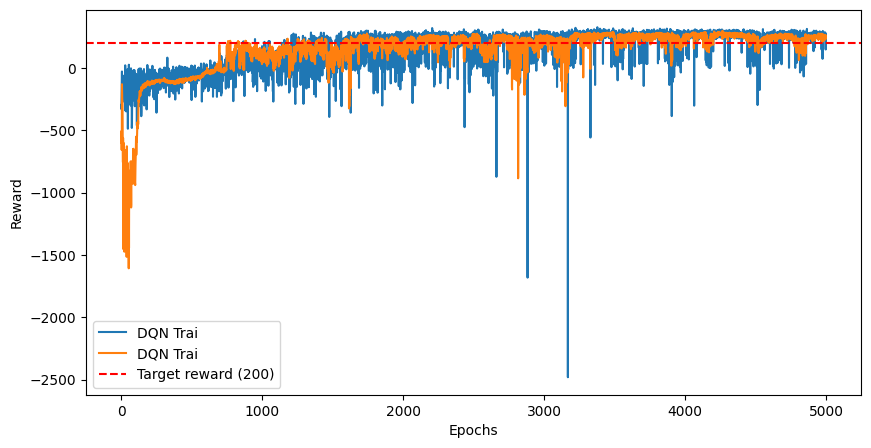

##### ${\color{orange}{\text{orange graph is validation rewards  }}}$ , ${\color{cyan}{\text{blue graph is train rewards}}}$


We got the best model (in episode 3107):  
Average reward is 271.43, the accuracy is 4999/5000  (99.98 \%)

Which is pretty good!

**We had some problems at the start**\
The epsilon decaying very fast (after less than 2000 episodes ) which affected the result and gave us worse results (very unstable graph with big spikes)  
we started with epsilon decay = $0.9$ and then changed to $0.999$ which improved a lot!  
As we see in the graph, it takes about 1000 episodes for the spaceship to get over 200 rewards, so with a higher epsilon decay it improved much.


Also, at the start we took only the model that got the highest validation reward, which gave sub optimal results,
then we decided to saved all the previous models that had a validation reward bigger than some treshold (out of all the episodes we run) and some of those models performed better in our testing.

---

# ${\color{lime}{\text{Double DQN }}}$


In [ ]:
def optimize_model_ddqn(env,policy_net,target_net,optimizer,memory,gamma,epsilon,epsilon_min,epsilon_decay,batch_size,target_update_freq,episodes): 
    
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)           
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)         #(state, action, reward, next_state, done)

    state_batch = torch.FloatTensor(np.array(state_batch))                                      #getting to tensors so it will be nice to work with
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    with torch.no_grad():

        next_actions = torch.argmax(policy_net(next_state_batch), dim=1, keepdim=True)          # select best action for each next state (with policy_net)                   
       
        max_next_q_values = target_net(next_state_batch).gather(1, next_actions).squeeze()      # evaluate that action's value (with target_net)                                                 

        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)           # r + gamma * max(q) 

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()       
    loss.backward()                 #backpropogation part!!!
    optimizer.step()

    return loss.item() 

In [ ]:
def double_dqn(env,policy_net,target_net,optimizer,memory,gamma,epsilon,epsilon_min,epsilon_decay,batch_size,target_update_freq,episodes):

    # Main training loop
    rewards_per_episode = []
    validation_rewards = []
    time_array = []
    steps_done = 0
    max_val_reward=-1000

    for episode in range(episodes):
        
        start_time=time.time()

        policy_net.train()
        target_net.eval()
        state,_ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:

            action = select_action(env,policy_net,state, epsilon)  #HI

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            memory.append((state, action, reward, next_state, done))                # Store transition in memory        
            
            state = next_state            
            episode_reward += reward
            
            optimize_model_ddqn(env,policy_net,target_net,optimizer,memory,gamma,epsilon,epsilon_min,epsilon_decay,batch_size,target_update_freq,episodes)

            
            if steps_done % target_update_freq == 0:                                # Update target sometimes
                target_net.load_state_dict(policy_net.state_dict())         

            steps_done += 1

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        
        rewards_per_episode.append(episode_reward)

        current_time=time.time()
        training_time = current_time - start_time
        time_array.append(np.round(training_time,2))

        validation_rewards.append( validate(env,policy_net) )
        print(f"episode {episode+1}/{episodes}, Train Reward: {episode_reward:.4f}, Avarage evaluation Reward: {validation_rewards[-1]:.4f}, Time: {time_array[-1]}")


        # Save....
        
        if validation_rewards[-1]>=200 and max_val_reward<=validation_rewards[-1]:
            max_val_reward=validation_rewards[-1]
            print("got in total_val_reward>=200 and max_val_reward<=total_val_reward")
            torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'target_net_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'episode': episode,
                'rewards_per_episode': rewards_per_episode,
                'epsilon': epsilon,
                'memory': memory,
                'validation_rewards': validation_rewards,
                'time_array': time_array
                }, f'checkpoint_{episode}.pt')


    torch.save({
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode,
        'rewards_per_episode': rewards_per_episode,
        'epsilon': epsilon,
        'memory': memory,
        'validation_rewards': validation_rewards,
        'time_array': time_array
        }, f'checkpoint_{episode}.pt')
    env.close()

    return rewards_per_episode,validation_rewards


In [ ]:
env = gym.make("LunarLander-v3")        #env = gym.make("LunarLander-v3",render_mode="human")


policy_net,target_net,optimizer,memory = initialize_all(env,learning_rate,memory_size)

rewards_per_episode,validation_rewards = double_dqn(env,policy_net,target_net,optimizer,memory,gamma,epsilon,epsilon_min,epsilon_decay,batch_size,target_update_freq,episodes)



plot_rewards(5000,rewards_per_episode,validation_rewards)

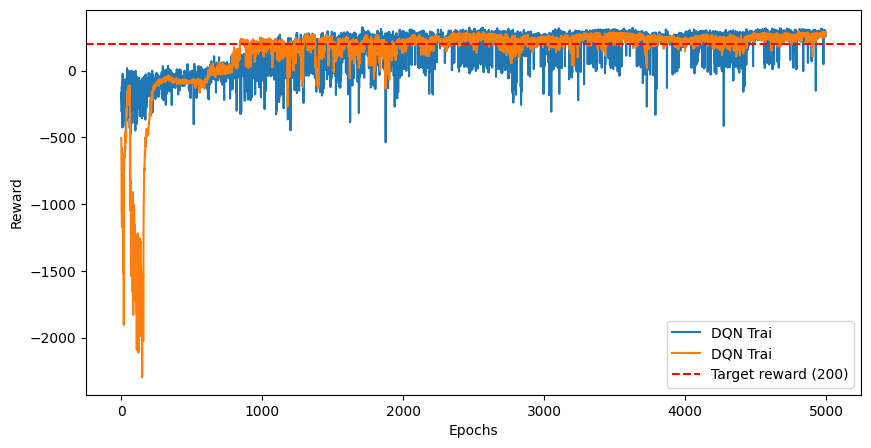

##### ${\color{orange}{\text{orange graph is validation rewards  }}}$ , ${\color{cyan}{\text{blue graph is train rewards}}}$

We got the best model (in episode 2806):  
Average reward is 272.22, the accuracy is 4790/5000 (95.8 \%)

We got a better avg rewards but no better accuracy than the normal DQN 

Also the graph looks more stable (no big spikes !)

-----

----

----

# ${\color{lime}{\text{Hyperparameter-Tuning:\ }}}$


#### ${\color{cyan}{\text{DQN}}}$

In [12]:
# Hyperparameters
learning_rate = 1e-4
gamma = 0.99
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000

# not important as the other parameters
epsilon = 1.0
epsilon_min = 0.01
memory_size = 10000
episodes = 5000

Since it takes a lot of times, We will check only a couple of hyperparameters.


model 2: learning rate = 0.001 


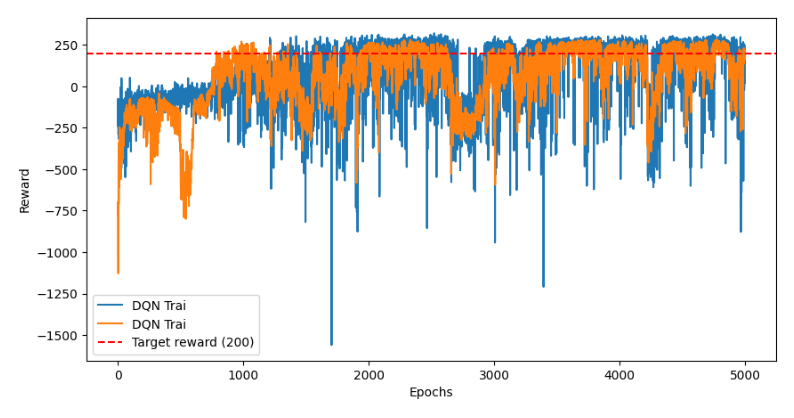

model 3: learning rate = 0.001 , batch_size = 128


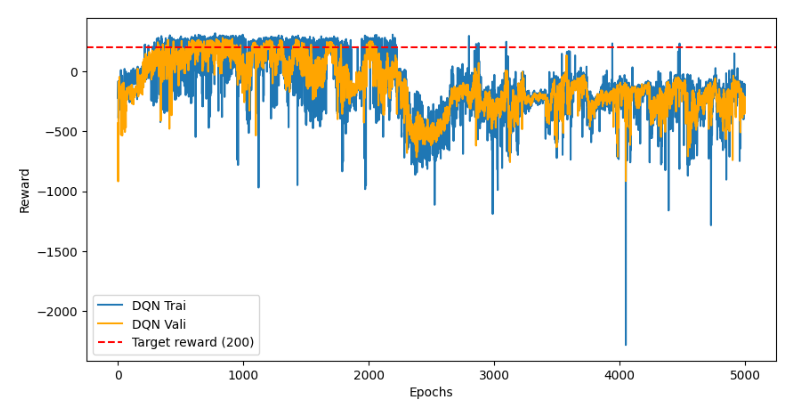

model 4: learning_rate = 0.0001, batch_size = 128


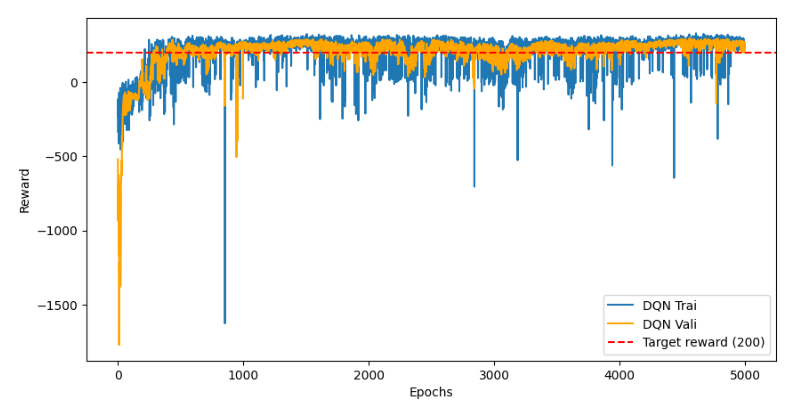

model 5: learning_rate = 0.0001, batch_size = 64, gamma = 0.995


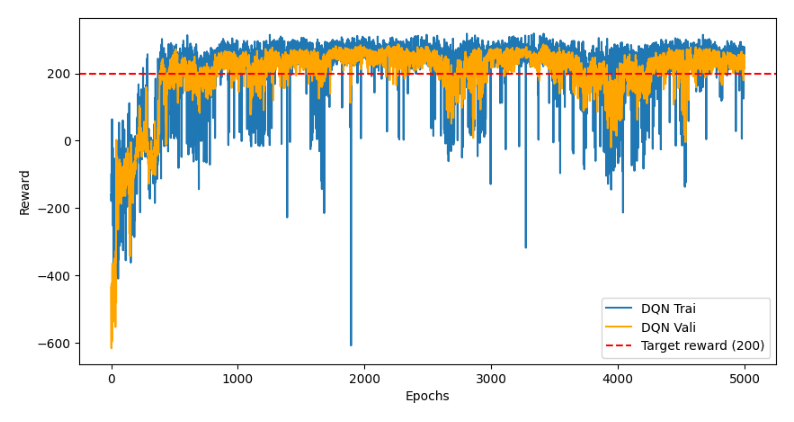

model 6: learning_rate = 0.0001, batch_size = 64, gamma = 0.99, epsilon_decay = 0.99


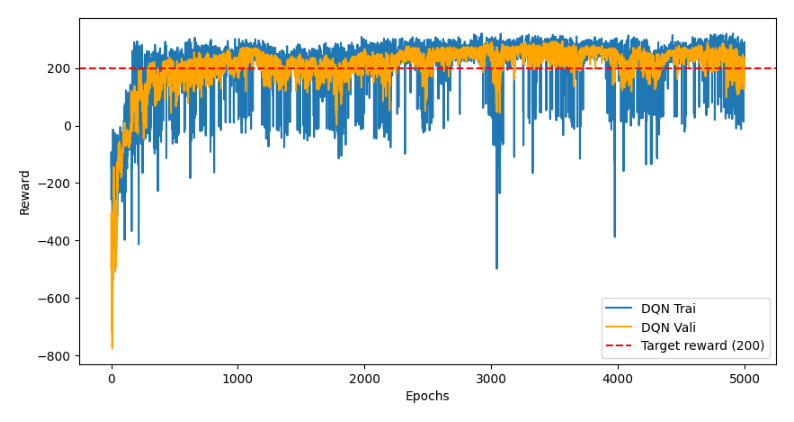

model 7: learning_rate = 0.001, batch_size = 64, gamma = 0.99, epsilon_decay = 0.99


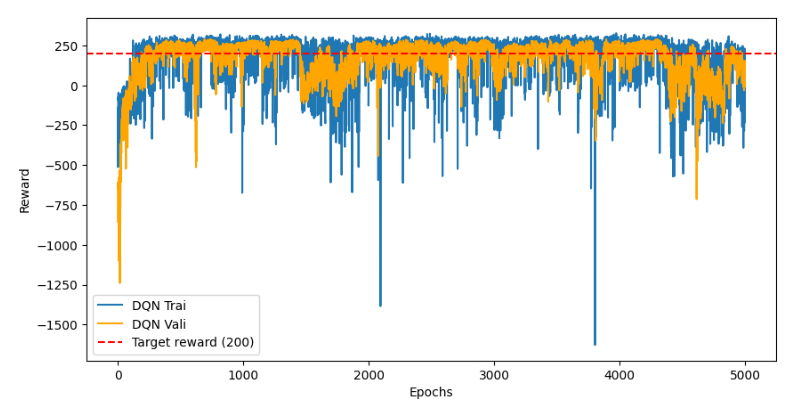

model 8: learning_rate = 0.0001, batch_size = 64, gamma = 0.99, epsilon_decay = 0.995, target_update_freq = 5000


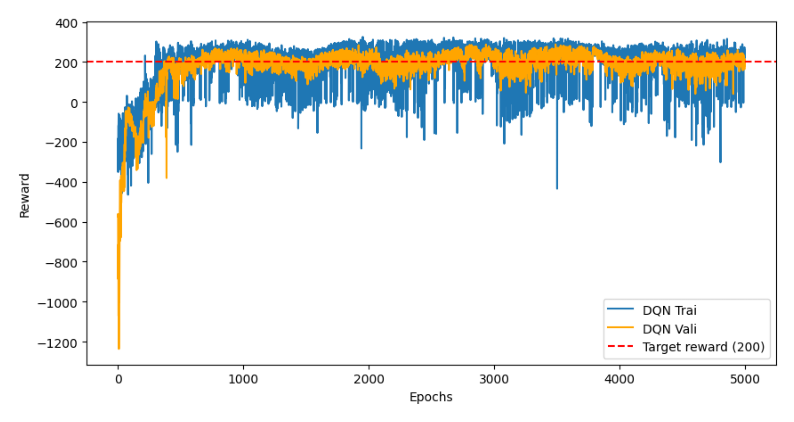

In [ ]:
rewards_train_saved = []
reward_vali_saved = []
max_val_reward_overall = []
max_model_name = 3
model_num = 3  

param_groups = [
    {"learning_rate":1e-3},
    {"learning_rate": 1e-3, "batch_size": 128},
    {"learning_rate": 1e-4, "batch_size": 128},
    {"learning_rate": 1e-4, "batch_size": 64,  "gamma": 0.995},
    {"learning_rate": 1e-4, "batch_size": 64,  "gamma": 0.99, "epsilon_decay": 0.99},
    {"learning_rate": 1e-3, "batch_size": 64,  "gamma": 0.99, "epsilon_decay": 0.99},
    {"learning_rate": 1e-4, "batch_size": 64,  "gamma": 0.99, "epsilon_decay": 0.995, "target_update_freq": 5000}
]

default_params = {
    "learning_rate": 1e-4,
    "batch_size": 64,
    "gamma": 0.99,
    "epsilon": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995,
    "target_update_freq": 1000,
    "memory_size": 10000,
    "episodes": 500
}

for group in param_groups:
    print(f"\n Running model {model_num} with config: {group}")
    env = gym.make("LunarLander-v3")

    # Get parameters from config or default
    learning_rate      = group.get("learning_rate", default_params["learning_rate"])
    batch_size         = group.get("batch_size", default_params["batch_size"])
    gamma              = group.get("gamma", default_params["gamma"])
    epsilon            = default_params["epsilon"]
    epsilon_min        = default_params["epsilon_min"]
    epsilon_decay      = group.get("epsilon_decay", default_params["epsilon_decay"])
    target_update_freq = group.get("target_update_freq", default_params["target_update_freq"])
    memory_size        = default_params["memory_size"]
    episodes           = default_params["episodes"]

    policy_net, target_net, optimizer, memory = initialize_all(env, learning_rate, memory_size)

    rewards_per_episode, validation_rewards = dqn_real(env, policy_net, target_net, optimizer, memory,gamma, epsilon, epsilon_min, epsilon_decay,batch_size, target_update_freq, episodes)

    max_val_reward_overall.append(max(validation_rewards))      # save each besto

    plot_rewards(episodes, rewards_per_episode, validation_rewards)

    env.close()
    model_num += 1

print(f"the max reward was from model:{max_model_name} and it was: {max_val_reward_overall}")

Out of the Hyperparameters Tuning models, the best were:

**Model 5**: learning_rate = 0.0001, batch_size = 64, gamma = 0.995:    
Average reward is 259.05, the accuracy is 4879/5000 (97.58 \%)  

**Model 7**: learning_rate = 0.001, batch_size = 64, gamma = 0.99, epsilon_decay = 0.99    
Average reward is 266.09, the accuracy is 4863/5000 (97.26 \%)

still not better than the first.

-----

## ${\color{lime}{\text{Hyperparameter-Tuning:\ }}}$


#### ${\color{cyan}{\text{Double DQN}}}$

model 2: learning rate = 0.001 


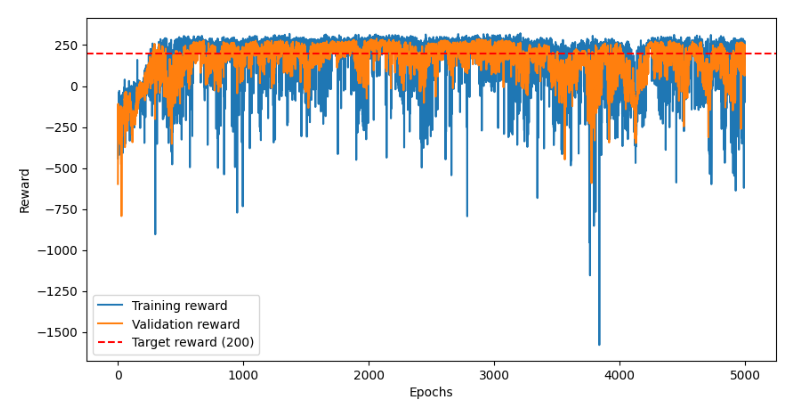

model 3: learning rate = 0.001 , batch_size = 128


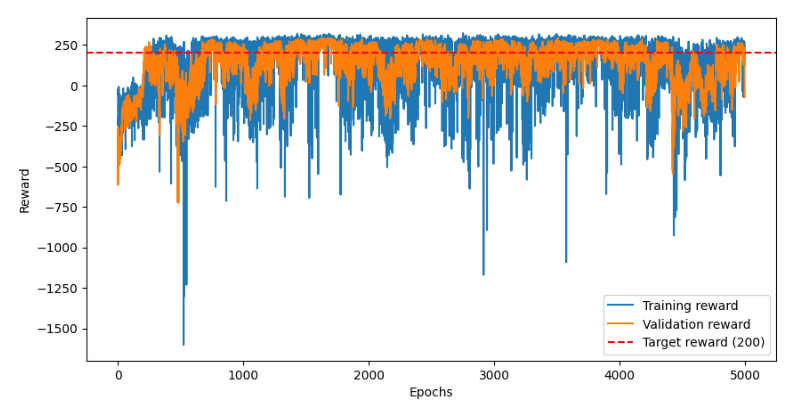

model 4: learning_rate = 0.0001, batch_size = 128


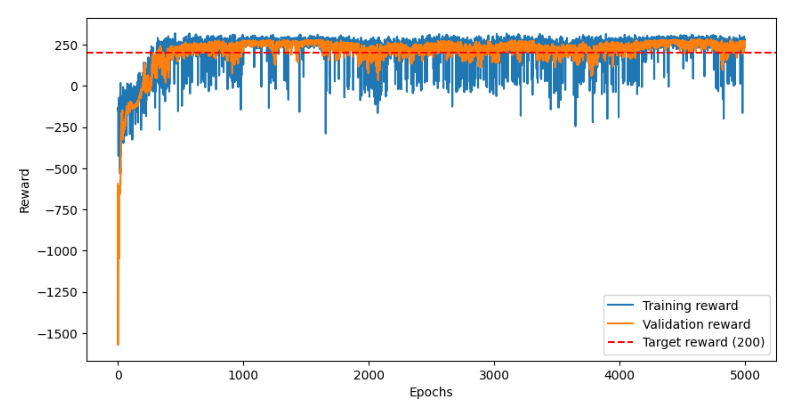

model 5: learning_rate = 0.0001, batch_size = 64, gamma = 0.995


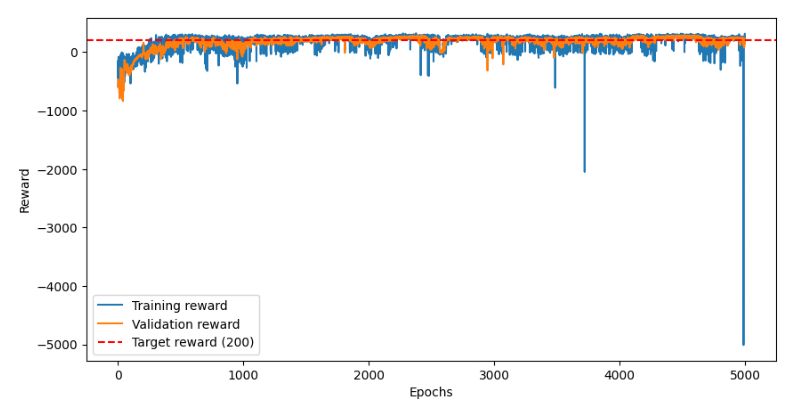

model 6: learning_rate = 0.0001, batch_size = 64, gamma = 0.99, epsilon_decay = 0.99


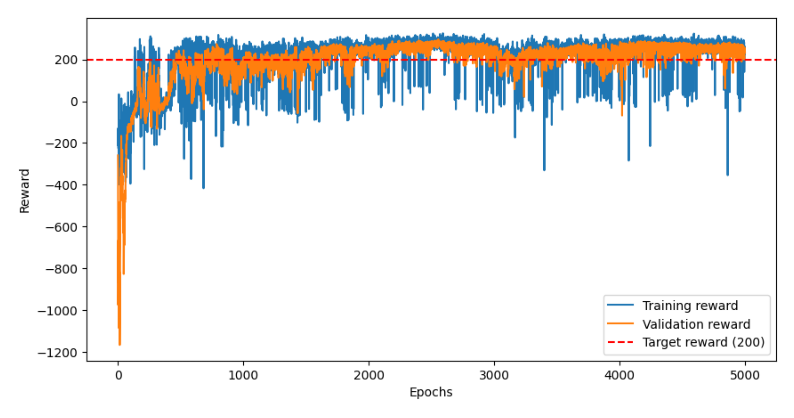

In [ ]:
rewards_train_saved = []
reward_vali_saved = []
max_val_reward_overall = []
max_model_name = 3
model_num = 3  

param_groups = [
    {"learning_rate":1e-3},
    {"learning_rate": 1e-3, "batch_size": 128},
    {"learning_rate": 1e-4, "batch_size": 128},
    {"learning_rate": 1e-4, "batch_size": 64,  "gamma": 0.995},
    {"learning_rate": 1e-4, "batch_size": 64,  "gamma": 0.99, "epsilon_decay": 0.99}
]

default_params = {
    "learning_rate": 1e-4,
    "batch_size": 64,
    "gamma": 0.99,
    "epsilon": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995,
    "target_update_freq": 1000,
    "memory_size": 10000,
    "episodes": 500
}

for group in param_groups:
    print(f"\n Running model {model_num} with config: {group}")
    env = gym.make("LunarLander-v3")

    # Get parameters from config or default
    learning_rate      = group.get("learning_rate", default_params["learning_rate"])
    batch_size         = group.get("batch_size", default_params["batch_size"])
    gamma              = group.get("gamma", default_params["gamma"])
    epsilon            = default_params["epsilon"]
    epsilon_min        = default_params["epsilon_min"]
    epsilon_decay      = group.get("epsilon_decay", default_params["epsilon_decay"])
    target_update_freq = group.get("target_update_freq", default_params["target_update_freq"])
    memory_size        = default_params["memory_size"]
    episodes           = default_params["episodes"]

    policy_net, target_net, optimizer, memory = initialize_all(env, learning_rate, memory_size)

    rewards_per_episode, validation_rewards = double_dqn(env, policy_net, target_net, optimizer, memory,gamma, epsilon, epsilon_min, epsilon_decay,batch_size, target_update_freq, episodes)

    max_val_reward_overall.append(max(validation_rewards))      # save each besto

    plot_rewards(episodes, rewards_per_episode, validation_rewards)

    env.close()
    model_num += 1

print(f"the max reward was from model:{max_model_name} and it was: {max_val_reward_overall}")

Out of the Hyperparameters Tuning models, the best were:

Model 3: learning rate = 0.001 , batch_size = 128:      
Average reward is 276.16, the accuracy is 4942/5000 (98.84 \%)

Model 4: learning_rate = 0.0001, batch_size = 128:    
Average reward is 268.75, the accuracy is 4933/5000 (98.66 \%)

We got a better avg reward but still no better accuracy than the first DQN model.

-----

As we can see, the training and validation graph looks more stable than the normal DQN(no big spikes).  
Also in some of the graphs we get results over 200 reward a bit faster than normal DQN(with the same hyper parameters).

# ${\color{lime}{\text{Results:}}}$

The Best DQN model gave us:  
Average reward is 271.43,  Accuracy is 4999/5000 (99.98 \%)

While the best Double DQN model gave us:  
Average reward is 276.17, the accuracy is 4942/5000 (98.84 \%)



------------------

# ${\color{lime}{\text{Actor Critic}}}$

The main purpose of the Actor Critic algorithm is that we have 2 models (in our case, a neural network), the first model is actor and the other is critic. <br>
The purpose of the actor is to play or, in our case, to tell the spaceship to activate which engine, and the critic's goal is to criticize the actor's choice, whether it was good or bad.<br> It can resemble the Generator and Discriminator in deep learning, but the difference is that in AC the two models are working together and helping each other, meanwhile in GAN the two models compete with each other, GAN is similar to the ping pong game, while AC is similar to the popular beach game paddles.<br>
In more detail, the actor's job is to evaluate the policy $\pi(u|x,\theta)$ which I will add isn't necessarily deterministic, and the critic's job is to evaluate the value function $v(x|\omega)$ ($x,\omega,\theta,u$ are the action, actor's parameters, critic's parameters and the action correspondently).<br>
However, before we begin discussing the actual algorithm of AC, we will need to provide a brief recap of the definitions and theorems already learned.

### ${\color{cyan}{\text{Theoretical material \& algorithm}}}$

**Theorem: Policy Gradient**<br>
Given an objective function (metric) $J(\theta)$ for the undiscounted episodic tasks and a parameterizable policy $\pi(u|x, \theta)$ the policy gradient is
$$
\nabla_\theta J(\theta)= \mathbb{E}_\pi \left[ q_\pi(x,u) \nabla_\theta ln \ \pi (u | x,\theta)\right]
$$ 
(from the lecturer Idan's lecture presentation and from the lecture book of Barto and Sutton).<br>
but how can we retrieve the action value $q_\pi(x,u)$?<br>
In actor-critic, we will use the advantage function.<br>

**Definition: Baseline and Advantage function**<br>
The baseline is defined as $b(x)$ (dependent only on the state), and is used in the gradient of the objective function
    $$
    \nabla_\theta J(\theta)= \mathbb{E}_\pi \left[ (q_\pi(x,u)-b(x)) \nabla_\theta ln \ \pi (u | x,\theta)\right]
    $$ 
    if we will choose $b(x) = v_\pi(x)$ the difference $q_\pi(x,u)-v_\pi(x)$ defines the advantage function $a(x,u)=q_\pi(x,u)-v_\pi(x)$<br>
    <br>
Thus we get
$$
\nabla_\theta J(\theta)=\mathbb{E}_\pi \left[ a(x,u) \nabla_\theta ln \ \pi (u | x,\theta)\right]
$$
Important to add that because $b(x)$ depends only in the state and not the action, $ \mathbb{E}_\pi \left[b(x) \nabla_\theta ln \ \pi (u | x,\theta)\right] =0$ and the equation holds.<br>
We will discuss 2 variations:<br>

### ${\color{cyan}{\text{Variation 1 - TD(0)}}}$

The main idea of TD(0) (TD stands for Temporal Difference) is that each step/update of the model happens at every step, meaning that if we are in the state $x$<br> did the action $u$ got the reward $R$ and now in the state $x'$, the current update will be based only on this information, and not at any other information. <br>
The TD(0) error is 
$$
\delta_{\pi} = R + \gamma v_{\pi}(x') - v_{\pi}(x)
$$
We will calculate it using our approximation with the critic.
$$
\delta_{\pi} = R + \gamma v_{\pi}(x',\omega) - v_{\pi}(x,\omega)
$$

Where $R$ is the reward, $x$ is the current state,$\gamma$ is the discount factor and $x'$ is the next state.<br>
The TD error can be used as an advantage funciton, because
$$
\mathbb{E}_\pi \left[ \delta_\pi | x, u \right] = \mathbb{E}_\pi \left[ r + \gamma v_\pi(x') | x, u \right] - v_\pi(x) \\
= q_\pi(x, u) - v_\pi(x) \\
= a_\pi(x, u)
$$
Thus we get (in expected value)
$$
\nabla_\theta J(\theta)= \delta \nabla_\theta ln \ \pi (u | x,\theta)
$$
Therefore, the update rule for the actor will be (gradient ascend)
$$
\Delta \theta =\alpha_\theta*\nabla_\theta J(\theta) =\alpha_\theta \gamma^k \delta \nabla_\theta ln \ \pi (u | x,\theta)
$$
Where $\alpha_\theta$ is the learning rate, this is gradient ascent.
For the critic's update rule, we will want to minimize the temporal difference error- $\delta$.
$$
L(\omega)=\frac{1}{2} \delta^2 =\frac{1}{2} ( R + \gamma v_{\pi}(x',\omega) - v_{\pi}(x,\omega))^2
$$
$$
\nabla_\omega L(\omega)= ( R + \gamma v_{\pi}(x',\omega) - v_{\pi}(x,\omega)) (\gamma \nabla_\omega v_{\pi}(x',\omega) - \nabla_\omega v_{\pi}(x,\omega))= \delta (\gamma \nabla_\omega v_{\pi}(x',\omega) - \nabla_\omega v_{\pi}(x,\omega))
$$
In most applications, we will simplify the gradient to be $\nabla_\omega L(\omega)=-\delta \nabla_\omega v_{\pi}(x,\omega)$ (the $\gamma \nabla_\omega v_{\pi}(x',\omega)$ part was dropped).
The main idea for doing this is that we pretend that our target is $R + \gamma v_\pi(x',\omega)$ and $v_\pi(x,\omega)$ is the prediction. The idea is not to just minimize the error, it's to make our "prediction" similar to our "target", and by that we will minimize the error. <br>
There will be a comparison between dropping and not dropping next.
Thus, the update rule for the critic will be
$$
\Delta \omega =-\alpha_\omega \nabla_\omega L= \alpha_\omega  \delta \nabla_\omega v(x,\omega)
$$
Where $\alpha_\omega$ is the learning rate, this is gradient descent.<br>

Therefore, we get this pseudo code-
(This is the code from the lecturer Idan Tobis lecture notes).

$$
\begin{aligned}
&\textbf{input:} \text{ a differentiable policy function } \pi(u|x, \theta) \text{ and state-value function } \hat{v}(x, w) \\
&\textbf{parameter:} \text{ step sizes } \{\alpha_w, \alpha_\theta\} \in \mathbb{R},\ 0 < \alpha < 1 \\
&\textbf{init:} \text{ parameter vectors } w \in \mathbb{R}^\zeta \text{ and } \theta \in \mathbb{R}^d \text{ arbitrarily} \\
&\textbf{for } j = 1, 2, \ldots, \text{ episodes do} \\
&\text{initialize } x_0 \\
&\textbf{for } k = 0, 1, \ldots, T - 1 \text{ time steps do} \\
&\quad u_k \sim \pi(\cdot | x_k, \theta) \text{ and observe } x_{k+1} \text{ and } r_{k+1} \\
&\quad \delta \leftarrow r_{k+1} + \gamma \hat{v}(x_{k+1}, \omega) - \hat{v}(x_k, \omega) \\
&\quad \omega \leftarrow \omega + \alpha_\omega \delta \nabla_\omega \hat{v}(x_k, \omega) \\
&\quad \theta \leftarrow \theta + \alpha_\theta \gamma^k \delta \nabla_\theta \ln \pi(u_k | x_k, \theta)
\end{aligned}
$$
(In the code we do optimizer adam and not like this, but this is the main idea)<br>

**Remark**
The addition of $\gamma^k$ to
$\theta \leftarrow \theta + \alpha_\theta \gamma^k \delta \nabla_\theta \ln \pi(u_k | x_k, \theta)$
is called REINFORCE.

### ${\color{cyan}{\text{Variation 2 - TD(λ)}}}$

The second variation is TD($\lambda$) using backward view. <br> 
This variation is very similar to the first version but now we will add a new term called - "eligibility tracer".  <br> 
This approach is very similar to the one of TD(0), but with one key difference. Now, when we update the weights, we accumulate the gradient into a parameter called $z$, and update with it, so every time we update the weights, we take into account not only the current action gradient, but every gradient from the beginning of the episode.<br>
It looks like that: $z_k = \gamma \lambda z_{k-1}+\nabla_\omega \hat v (x_k, \omega_k)$
At first glance, we don't see the accumulation, so let's write it in more details.
$$
z_1=\nabla_\omega \hat v (x_1, \omega_1) \\
$$
update weights and state, $\omega_1 \to \omega_2$,$x_1 \to x_2$
$$
z_2=\gamma \lambda z_1 + \nabla_\omega \hat v (x_2, \omega_2)=\gamma \lambda \nabla_\omega \hat v (x_1, \omega_1)+\nabla_\omega \hat v (x_2, \omega_2) 
$$
...
$$
z_k=\gamma \lambda z_{k-1} + \nabla_\omega \hat v (x_k, \omega_k)=\gamma^2 \lambda^2 z_{k-2}+ \gamma \lambda \nabla_\omega \hat v (x_{k-1}, \omega_{k-1}) + \nabla_\omega \hat v (x_k, \omega_k)=
$$
$$
= \gamma^{k-1} \lambda^{k-1} \nabla_\omega \hat v (x_1, \omega_1)+\gamma^{k-2} \lambda^{k-2} \nabla_\omega \hat v (x_2, \omega_2)+...+\gamma \lambda \nabla_\omega \hat v (x_{k-1}, \omega_{k-1}) + \nabla_\omega \hat v (x_k, \omega_k)
$$
Now it is clear how the eligibility traces work (Same goes for the actor).<br> 
Let's see how the algorithm will work for $TD(\lambda)$.<br> 
**Input:** a differentiable policy function $\pi(u|x, \theta)$  
**Input:** a differentiable state-value function $\hat{v}(x, \omega)$  
**Parameter:** $\{\alpha_\omega, \alpha_\theta\} \in \{\mathbb{R} \mid 0 < \alpha < 1\}, \{\lambda_\omega, \lambda_\theta\} \in \{\mathbb{R} \mid 0 \leq \lambda \leq 1\}$  
**Init:** parameter vectors $\omega \in \mathbb{R}^s$ and $\theta \in \mathbb{R}^d$ arbitrarily  

**for** $j = 1, 2, \ldots$, episodes **do**  
initialize $x_0$, $z_\omega = 0$, $z_\theta = 0$  

**for** $k = 0, 1, \ldots, T-1$ time steps **do**  
apply $u_k \sim \pi(\cdot | x_k, \theta)$ and observe $x_{k+1}$ and $r_{k+1}$  

$$
\begin{aligned}
\delta &\gets r_{k+1} + \gamma \hat{v}(x_{k+1}, \omega) - \hat{v}(x_k, \omega) \\
z_\omega &\gets \gamma \lambda_\omega z_\omega + \nabla_\omega \hat{v}(x_k, \omega) \\
z_\theta &\gets \gamma \lambda_\theta z_\theta + \gamma^k \nabla_\theta \ln \pi(u_k | x_k, \theta) \\
\omega &\gets \omega + \alpha_\omega \delta z_\omega \\
\theta &\gets \theta + \alpha_\theta \delta z_\theta
\end{aligned}
$$  

**end for**  
**end for**  
(In the code we do optimizer adam and not like this, but this is the main idea)

Now, after we finished to go through the theoretical part, let's see the AC code.

In [5]:
actor_learning_rate =  0.0005
critic_learning_rate = 0.001
num_epsiodes = 5000
gamma=0.995
state_size=observation.shape[0] # should be 8
action_space_size=4

In [14]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        dist = torch.distributions.Categorical(x)
        return dist


class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def validate_AC(env,actor):
    actor.eval()
    total_val_reward = 0.0
    with torch.no_grad():
        num=10
        for i in range(num): #evaluate avarage reward on num episodes.
            terminated=False
            truncated=False
            state, _ = env.reset()
            state = torch.from_numpy(state).float().unsqueeze(0)
            current_val_episode_reward=0
            while not(terminated or truncated):
                # get action, a ~ Pi( \dot|state,theta)
                action_dist=actor(state)
                action = action_dist.sample()
                action = action.item()

                # sample using the action.
                state,reward,terminated,truncated,_=env.step(action)
                state = torch.from_numpy(state).float().unsqueeze(0)

                                    
                current_val_episode_reward+=reward
            total_val_reward+=current_val_episode_reward/num # I want to avarage the reward over num episodes.
    return total_val_reward

In [29]:
def save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,file_name):
    torch.save({
    'actor': actor.state_dict(),
    'critic': critic.state_dict(),
    'optimizer_actor': optimizer_actor.state_dict(),
    'optimizer_critic': optimizer_critic.state_dict(),
    'episode': episode,
    'total_val_reward': total_val_reward,
    'test_rewards': test_rewards,
    'train_rewards': train_rewards,
    'training_seconds': np.round(training_time%60,2),
    'training_minutes': np.round(training_time/60,2),
    'time_array': time_array,
}, file_name)

In [19]:
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)


optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

print(f"parameters: {sum(p.numel() for p in actor.parameters() if p.requires_grad)}")
print(f"parameters: {sum(p.numel() for p in critic.parameters() if p.requires_grad)}")

parameters: 1668
parameters: 1281


We have 4 code versions for the training, but let's take it part by part.

## ${\color{cyan}{\text{TD(0) Code.}}}$

I wanted to compare 2 versions of updating the critic, as explained in the theoretical part, <br>
1) $\nabla_\omega L(\omega)= \delta (\gamma \nabla_\omega v_{\pi}(x',\omega) - \nabla_\omega v_{\pi}(x,\omega))$ <br>
2) $\nabla_\omega L(\omega)= -\delta  \nabla_\omega v_{\pi}(x,\omega)$<br>

In [ ]:
def train_TD_zero_v1(env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,treshold=200,train_rewards=[],test_rewards=[],time_array=[]):
    max_val_reward=200
    start_time=time.time()
    pbar = tqdm(range(1,num_epsiodes)) # does tqdm bar, and shows a wanted variable value
    for episode in pbar:
        ''' Training '''
        actor.train()
        critic.train()
        state, _ = env.reset()
        state = torch.from_numpy(state).float().unsqueeze(0)
        terminated=False
        truncated=False
        total_train_reward=0
        number_of_steps=0
        while not(terminated or truncated):
            # get action, a ~ Pi( \dot|state,theta)
            action_dist=actor(state)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            action = action.item()

            #calculate the state's value
            value_state=critic(state)

            # sample using the action.
            state,reward,terminated,truncated,_=env.step(action)
            state = torch.from_numpy(state).float().unsqueeze(0)

            # calculate delta
            value_new_state=critic(state)*(1-truncated)*(1-terminated)
            delta=reward+gamma*value_new_state-value_state

            ''' critic gradient descent'''
            optimizer_critic.zero_grad()       # Reset gradients
            J_critic=delta.pow(2)
            J_critic.backward()
            optimizer_critic.step()

            '''actor gradient ascend'''
            optimizer_actor.zero_grad()       # Reset gradients
            J_actor=-log_prob * (delta.detach())
            J_actor.backward()
            optimizer_actor.step()
            
            total_train_reward+=reward
            number_of_steps+=1
            
        ''' evaluation '''
        total_val_reward=validate_AC(env,actor)
        train_rewards.append(total_train_reward)
        test_rewards.append(total_val_reward)
        current_time=time.time()
        training_time = current_time - start_time
        time_array.append(np.round(training_time,2))

        pbar.set_postfix({"val_reward": total_val_reward})
        if  max_val_reward<=total_val_reward or total_val_reward>=treshold:
            max_val_reward=total_val_reward
            save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
                          f'AC rewardV1 {np.round(total_val_reward,2)} episode {episode}.pt')


    end_time = time.time()
    training_time = end_time - start_time
    save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
                  f'last AC rewardV1 {np.round(total_val_reward,2)} episode {episode}.pt')

    return actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array=train_TD_zero_v1(env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma)
# 533m 25.5s

We validated at the end of an episode for 10 tests (after finishing one full training episode, we ran 10 games with the updated model and got the availability reward).<br>
The orange graph is the validation reward, the blue graph is the training reward (the reward of a full episode).

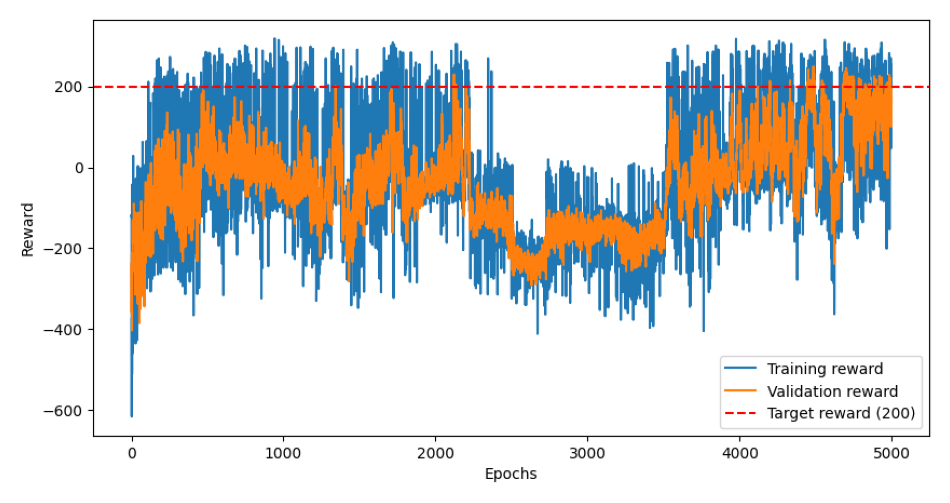

In [ ]:
plot_rewards(episode+1,train_rewards,test_rewards)

In [44]:
model = torch.load(r"model\second run no lambda\best_model1_4485.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [04:31<00:00, 18.40it/s]

avarage reward is 186.2470038161648, the accuracy is 70.54%, (3527/5000)


We run the code for 8 hours 53 minutes and 25.5 seconds. <br>
We can see that the training did very poorly, we did not have any clear convergence and by what you can call luck got some models with average reward of over 200.<br>
The second variation did MUCH better.<br>

In [17]:
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)


In [ ]:
def train_TD_zero_v2(env,actor,critic,optimizer_actor,optimizer_critic,scheduler_actor=None,scheduler_critic=None,num_epsiodes=5000,gamma=0.995,treshold=270,train_rewards=[],test_rewards=[],time_array=[]):
    max_val_reward=200
    start_time=time.time()
    pbar = tqdm(range(1,num_epsiodes)) # does tqdm bar, and shows a wanted variable value

    for episode in pbar:
        ''' Training '''
        actor.train()
        critic.train()
        state, _ = env.reset()
        state = torch.from_numpy(state).float().unsqueeze(0)
        terminated=False
        truncated=False
        total_train_reward=0
        gamma_power_number_of_step=1 # insted of calculating the power each loop which can be expensive, we save the value and each time
        #multilpy by gamma
        while not(terminated or truncated):
            # get action, a ~ Pi( \dot|state,theta)
            action_dist=actor(state)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            action = action.item()

            #calculate the state's value
            value_state=critic(state)

            # sample using the action.
            state,reward,terminated,truncated,_=env.step(action)
            state = torch.from_numpy(state).float().unsqueeze(0)

            # calculate the new state value and delta
            value_new_state=critic(state)*(1-truncated)*(1-terminated)
            delta=reward+gamma*value_new_state-value_state

            '''critic gradient descent'''
            optimizer_critic.zero_grad()  # Reset gradients
            J_critic = delta.detach().item() * -value_state
            J_critic.backward(retain_graph=False)
            optimizer_critic.step()

            '''actor gradient ascend'''
            optimizer_actor.zero_grad()       # Reset gradients
            J_actor=-log_prob *gamma_power_number_of_step* (delta.detach())
            J_actor.backward()
            optimizer_actor.step()
            
            total_train_reward+=reward
            gamma_power_number_of_step*=gamma
            
        ''' evaluation '''
        total_val_reward=validate_AC(env,actor) # I want to avarage the reward over 5 episodes.            
        train_rewards.append(total_train_reward)
        test_rewards.append(total_val_reward)
        current_time=time.time()
        training_time = current_time - start_time
        time_array.append(np.round(training_time,2))

        if scheduler_actor!=None and scheduler_critic!=None:
            scheduler_actor.step()
            scheduler_critic.step()
        pbar.set_postfix({"val_reward": total_val_reward})

        if  max_val_reward<=total_val_reward or total_val_reward>=treshold:
            max_val_reward=total_val_reward
            save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
                          f'AC reward {np.round(total_val_reward,2)} episode {episode}.pt')


    end_time = time.time()
    training_time = end_time - start_time
    save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
                  f'last AC reward {np.round(total_val_reward,2)} episode {episode}.pt')

    return actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array=train_TD_zero_v2(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes=num_epsiodes,gamma=gamma)
# 284m 55.4S


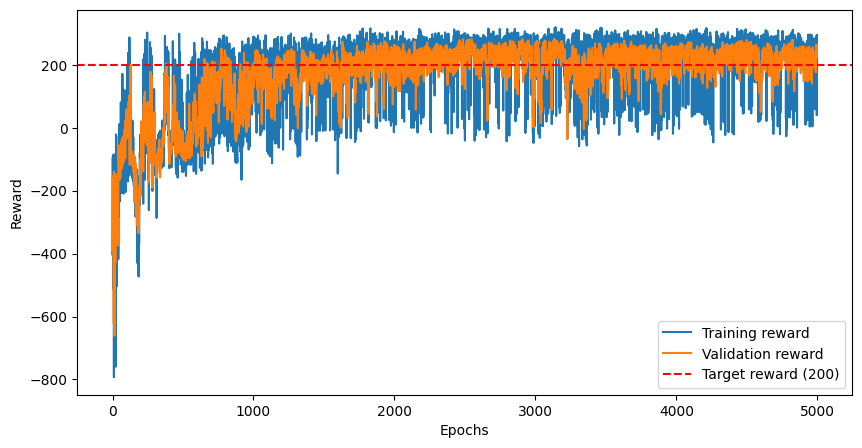

In [17]:
model = torch.load(r"model\third run no lambda new code 17.06 good too!\last_model4999.pt", weights_only=False)
number_of_val_epochs=5000
train_rewards=model["train_rewards"]
test_rewards=model["test_rewards"]
plot_rewards(5000,train_rewards,test_rewards)

In [18]:
model = torch.load(r"model\third run no lambda new code 17.06 good too!\best_model1_3135.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [03:58<00:00, 20.96it/s]

avarage reward is 258.6228121297523, the accuracy is 96.89999999999999%, (4845/5000)


We run the code for 7 hours, 7 minutes and 53.9 seconds.<br>
The average reward is 258.6228121297523, the accuracy is 96.9\%, (4845/5000) <br>
Now we can see excellent clear convergence, and getting a model average over 200 as we progress.<br>
Our conclusion for this part is that indeed as we learned in the course the superior option is to update the critic as $\nabla_\omega L(\omega)= -\delta  \nabla_\omega v_{\pi}(x,\omega)$.<br>
One can claim that the difference is because of hyper-parameter choosing, but in my opinion this isn't the case because of the clear chaos of the first variation. <br>
Furthermore, the training time in the second version was almost 2 hours less than in the first version, a big margin. 

## ${\color{cyan}{\text{TD(λ)}}}$

In [ ]:
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

print(f"parameters: {sum(p.numel() for p in actor.parameters() if p.requires_grad)}")
print(f"parameters: {sum(p.numel() for p in critic.parameters() if p.requires_grad)}")

parameters: 1668
parameters: 1281


In [ ]:
def train_TD_lambda(env,actor,critic,optimizer_actor,optimizer_critic,scheduler_actor=None,scheduler_critic=None,num_epsiodes=5000,gamma=0.995,lambda_actor=0.9,lambda_critic=0.9,train_rewards=[],test_rewards=[],time_array=[],treshold=270):
    max_val_reward=200
    start_time=time.time()
    pbar = tqdm(range(1,num_epsiodes)) # does tqdm bar, and shows a wanted variable value
    for episode in pbar:
        actor.train()
        critic.train()
        state, _ = env.reset()
        state = torch.from_numpy(state).float().unsqueeze(0)
        terminated=False
        truncated=False
        total_train_reward=0
        z_actor = [torch.zeros_like(p, device=device) for p in actor.parameters()]
        z_critic = [torch.zeros_like(p, device=device) for p in critic.parameters()]
        while not(terminated or truncated):
            # get action, a ~ Pi( \dot|state,theta)
            action_dist=actor(state)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            action = action.item()
            
            # sample using the action.
            value_state=critic(state)
            state,reward,terminated,truncated,_=env.step(action)
            state = torch.from_numpy(state).float().unsqueeze(0)
            value_new_state=critic(state)*(1-truncated)*(1-terminated)
            delta=reward+gamma*value_new_state-value_state

            '''critic gradient descent'''
            optimizer_critic.zero_grad()  # Reset gradients
            value_state.backward(retain_graph=True)  # retain_graph because we'll do actor.backward() after
            with torch.no_grad():
                for i, p in enumerate(critic.parameters()):
                    #elgibilty traces
                    z_critic[i] = gamma * lambda_critic * z_critic[i] + p.grad.detach()
                    # update the gradient to fit the formula when doing step.()
                    p.grad = -delta.detach().item() * z_critic[i]

            optimizer_critic.step()

            '''actor gradient ascend'''
            optimizer_actor.zero_grad()  # Reset gradients
            log_prob.backward()
            with torch.no_grad():
                for i, p in enumerate(actor.parameters()):
                    #elgibilty traces
                    z_actor[i] = gamma * lambda_actor * z_actor[i] + p.grad.detach()
                    # update the gradient to fit the formula when doing step.()
                    p.grad = -delta.detach().item() * z_actor[i]

            optimizer_actor.step()
            total_train_reward+=reward
        ''' evaluation '''
        total_val_reward=validate_AC(env,actor)
        current_time = time.time()
        training_time = current_time - start_time
        train_rewards.append(total_train_reward)
        test_rewards.append(total_val_reward)
        time_array.append(training_time)
        postfix = {"val_reward": total_val_reward}
        if scheduler_actor!=None and scheduler_critic!=None:
            scheduler_actor.step()
            scheduler_critic.step()
        
        pbar.set_postfix(postfix)
        if  max_val_reward<=total_val_reward or total_val_reward>=treshold:
            max_val_reward=total_val_reward
            save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
                        f'AC lambda reward {np.round(total_val_reward,2)} episode {episode}.pt')


    end_time = time.time()
    training_time = end_time - start_time
    save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
            f'last AC lambda reward {np.round(total_val_reward,2)} episode {episode}.pt')

    return actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array

### with $\lambda_{actor} =0.99$ and $\lambda_{critic} =0.99$

In the beginning we tried using $\lambda_{actor}=0.99,\lambda_{critic}=0.99$ but it failed miserably.

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,0.99,0.99)
# 371m 30.3s

4999
4999


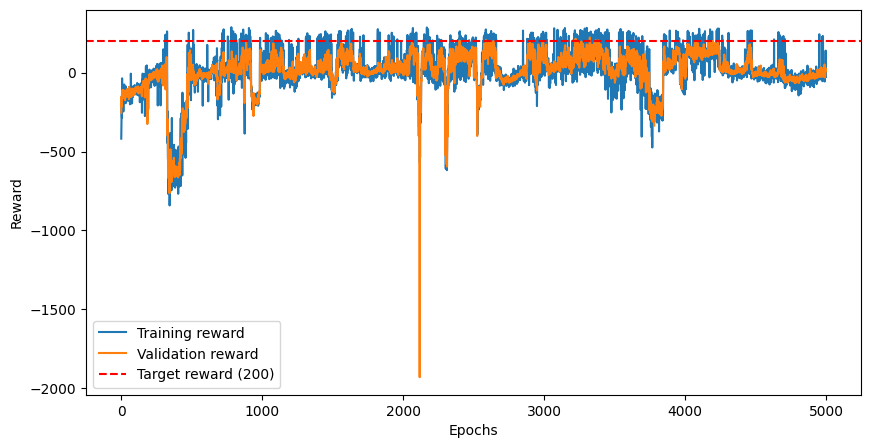

In [ ]:
plot_rewards(num_epsiodes,train_rewards,test_rewards)

In [39]:
model = torch.load(r"model\lambda 0.99, 0.99\best_model_actor_critic_lambda3325.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [05:42<00:00, 14.62it/s]

avarage reward is 177.9526046996237, the accuracy is 59.540000000000006%, (2977/5000)


We run the training for 6 hours 11 minutes and 30.3 seconds.<br>
As we can see, very bad results, and no convergence at all.<br>
But this is a hyper-parameter choice, because when we tried to use $\lambda_{actor}=0.9,\lambda_{critic}=0.9$ with the same code, the results were remarkably different.

### with $\lambda_{actor} =0.9$ and $\lambda_{critic} =0.9$

In [18]:
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,0.9,0.9)
# 365m 39.9s last time
# 241m 33.3s now

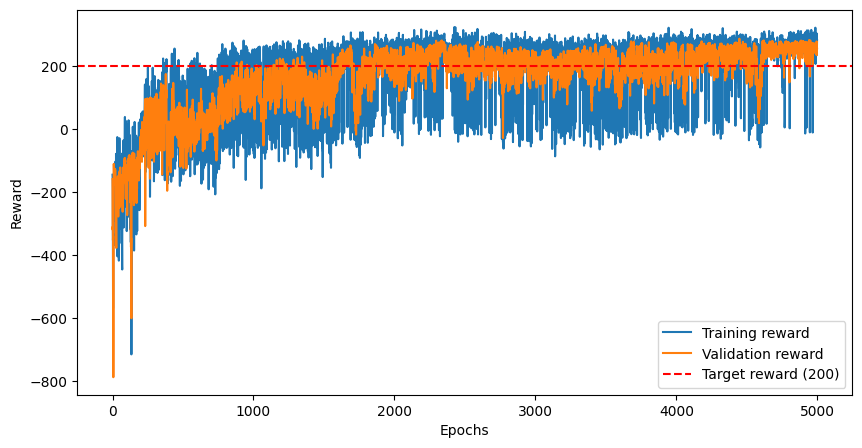

In [ ]:
plot_rewards(num_epsiodes,train_rewards,test_rewards) #last time

In [40]:
model = torch.load(r"model\lambda 0.9,0.9\first 5000\best_model_actor_critic_lambda4448.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [03:45<00:00, 22.17it/s]

avarage reward is 260.41460834208146, the accuracy is 97.04%, (4852/5000)


We run the code for 6 hours 5 minutes and 39.9 seconds.<br>
As we can see, great results.

### ${\color{cyan}{\text{TD(λ) with Reinforce}}}$

We wanted to see the effect of reinforce on the training, a reminder:<br>
The addition of $\gamma^k$ to
$\theta \leftarrow \theta + \alpha_\theta \gamma^k \delta \nabla_\theta \ln \pi(u_k | x_k, \theta)$
is called reinforce.<br>
This is the code of TD($\lambda$) with reinforce.

In [21]:
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

In [ ]:
def train_TD_lambda_with_reinforce(env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,lambda_actor,lambda_critic,train_rewards=[],test_rewards=[],time_array=[]):
    start_time = time.time()
    max_val_reward=200
    for episode in range(1, num_epsiodes):
        actor.train()
        critic.train()
        state, _ = env.reset()
        state = torch.from_numpy(state).float().unsqueeze(0)
        terminated=False
        truncated=False
        total_train_reward=0
        number_of_steps=0
        z_actor = [torch.zeros_like(p, device=device) for p in actor.parameters()]
        z_critic = [torch.zeros_like(p, device=device) for p in critic.parameters()]
        while not(terminated or truncated):
            # get action, a ~ Pi( \dot|state,theta)
            action_dist=actor(state)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            action = action.item()
            

            value_state=critic(state)
            # sample using the action.
            state,reward,terminated,truncated,_=env.step(action)
            state = torch.from_numpy(state).float().unsqueeze(0)
            value_new_state=critic(state)*(1-truncated)*(1-terminated)
            delta=reward+gamma*value_new_state-value_state

            '''critic gradient descent'''
            optimizer_critic.zero_grad()  # Reset gradients
            value_state.backward(retain_graph=True)  # retain_graph because we'll do actor.backward() after
            with torch.no_grad():
                for i, p in enumerate(critic.parameters()):
                    #elgibilty traces
                    z_critic[i] = gamma * lambda_critic * z_critic[i] + p.grad.detach()
                    # update the gradient to fit the formula when doing step.()
                    p.grad = -delta.detach().item() * z_critic[i]

            optimizer_critic.step()


            '''actor gradient ascend'''
            optimizer_actor.zero_grad()  # Reset gradients
            log_prob.backward(retain_graph=True)
            with torch.no_grad():
                for i, p in enumerate(actor.parameters()):
                    #elgibilty traces
                    z_actor[i] = gamma * lambda_actor * z_actor[i] + (gamma**number_of_steps)*p.grad.detach()
                    # update the gradient to fit the formula when doing step.()
                    p.grad = -delta.detach().item() * z_actor[i]

            optimizer_actor.step()
            number_of_steps+=1
            total_train_reward+=reward

        ''' evaluation '''
        total_val_reward=validate_AC(env,actor)
        train_rewards.append(total_train_reward)
        test_rewards.append(total_val_reward)
        current_time=time.time()
        training_time = current_time - start_time
        time_array.append(np.round(training_time,2))
        if  max_val_reward<=total_val_reward or total_val_reward>=275:
            
            max_val_reward=total_val_reward
            save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
                f'AC lambdaRE reward {np.round(total_val_reward,2)} episode {episode}.pt')

    end_time = time.time()
    training_time = end_time - start_time
    save_model_AC(actor,critic,optimizer_actor,optimizer_critic,episode,total_val_reward,test_rewards,time_array,train_rewards,training_time,
        f'last AC lambdaRE reward {np.round(total_val_reward,2)} episode {episode}.pt')
    return actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda_with_reinforce(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,0.9,0.9)
# 483m 19.8s

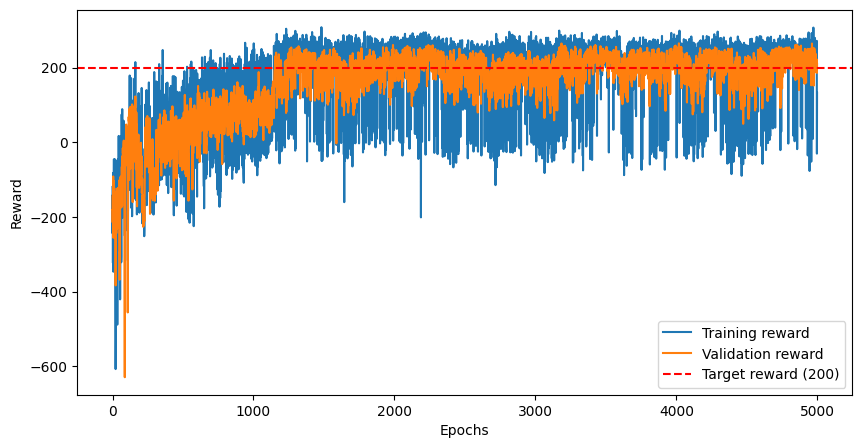

In [8]:
plot_rewards(num_epsiodes,train_rewards,test_rewards)

We run this code for 8 hours, 3 minutes, and 19.8 seconds.

In [43]:
model = torch.load(r"model\lambda reinforce\AC lambda reward 264.94 episode 4019.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:47<00:00, 17.37it/s]

avarage reward is 241.58758535556186, the accuracy is 93.2%, (4660/5000)


We can see that there isn't that much of a change between the graphs (using and not using reinforce), <br>so from now on we will stick to the code that doesn't use reinforce, because it the reinforce run much slower than without it.

## ${\color{cyan}{\text{Code improving and mistakes we had in AC}}}$

In this section, I will explain changes in the code that decreased the running time by quite a lot.<br> (the code added in the previous sections is the first code, here i write the parts of the code that made problems).<br>
Firstly, in every place I had this line:<br>
`state = torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)`<br>
by this line:<br>
`state=torch.from_numpy(state).float().unsqueeze(0)`<br>
Secondly, in the TD(0), I have changed this code block

<pre>
'''critic gradient descent'''
        optimizer_critic.zero_grad()  # Reset gradients
        value_state.backward(retain_graph=True)
        with torch.no_grad():
            for i, p in enumerate(critic.parameters()):
                # change the gradient to fit the formula when using .step()
                p.grad = -delta.detach().item() * p.grad.detach()
</pre>
To this,
<pre>
'''critic gradient descent'''
optimizer_critic.zero_grad()  # Reset gradients
J_critic = delta.detach().item() * -value_state
J_critic.backward(retain_graph=False)
optimizer_critic.step()
</pre>
(Removed $\texttt{retain\_graph=True}$ that takes running time, and made the amount of times we change the gradient from 2 to 1).

Thirdly,
we changed $\gamma$ from $\texttt{gamma=0.9999}$ to $\texttt{gamma=0.995}$ which is easier to compute.<br>
<br>
Fourthly,
we used to print each episode the current rewards, we switched it to tqdm, so it will be faster.<br>
After those changes, we run again the code of TD(0) (second version) and TD($\lambda$) ($\lambda_{critic}=0.9$,$\lambda_{actor}=0.9$, without REINFORCE), and got:

#### ${\color{cyan}{\text{TD(0)}}}$


About the same convergence, but the running time was shrunk from 7 hours, 7 minutes and 53.9 seconds to 4 hours, 44 minutes and 55.4 seconds, a big difference.

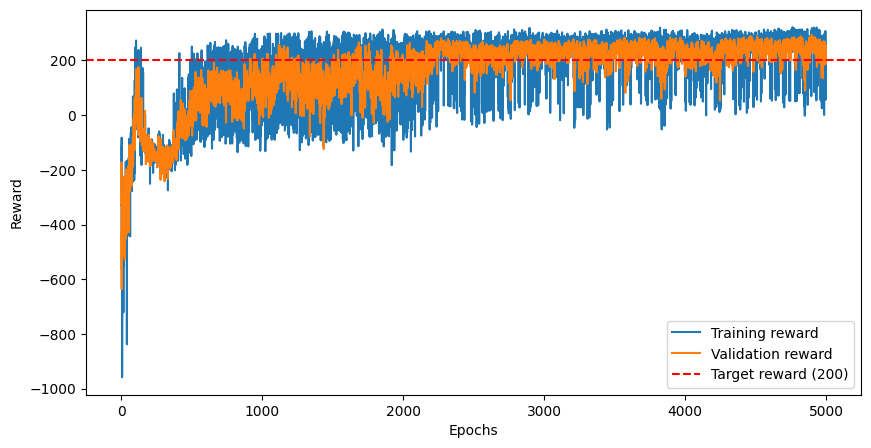

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array=train_TD_zero_v2(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes=num_epsiodes,gamma=gamma)
plot_rewards(5000,train_rewards,test_rewards)

The best model was 4910:

In [ ]:
model = torch.load(r"model\no lambda v2 best resluts so far 4900\AC reward 285.17 episode 4910.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [03:07<00:00, 26.62it/s]

avarage reward is 274.026848580312, the accuracy is 97.86%, (4893/5000)


#### ${\color{cyan}{\text{TD(λ)}}}$
Again, we got about the same convergence, but the running time was shrunk from 6 hours, 5 minutes and 39.9 seconds to 4 hours, 1 minutes and 33.3 seconds, a big difference.

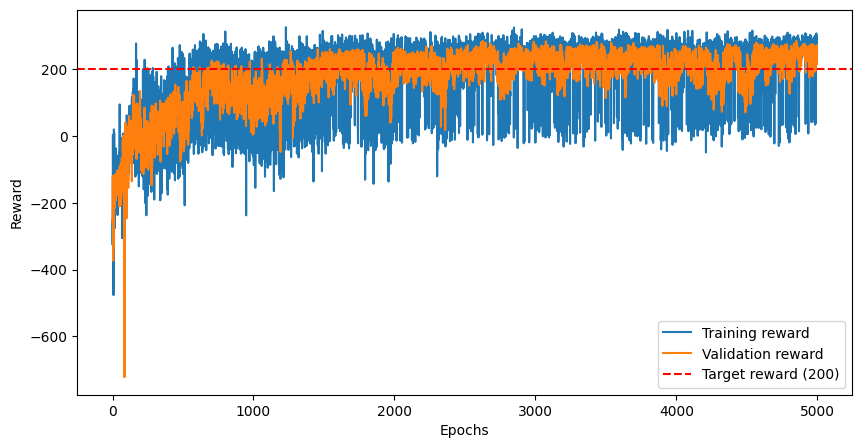

In [ ]:
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,0.9,0.9)
plot_rewards(num_epsiodes,train_rewards,test_rewards) 

The best model was after 4852 episodes:

In [ ]:
model = torch.load(r"model\running almbda 0.9 again, better results\AC lambda reward 285.74 episode 4852.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [03:20<00:00, 24.95it/s]

avarage reward is 269.90721998440097, the accuracy is 98.4%, (4920/5000)


## ${\color{cyan}{\text{Let's try to use different hyper parameters}}}$


We already saw the change of gamma in the previous section, but let's consider more things we can change: <br>
1) Add a scheduler.<br>
2) Change the learning rate.<br>
3) Run more episodes.<br>
4) Change lambda.<br>
5) Change the optimizer.<br>
6) Change the AC models.<br>

We won't do all of those options, because it will take a lot of computing power, and won't be necessary as we will see in the future.

We do the hyper parameter tuning only on TD(0) V2, and TD($\lambda$) because those were the best models.

### Smaller learning rates
We tried to make the learning rate smaller ($\texttt{actor\_learning\_rate = 0.0001}$, $\texttt{critic\_learning\_rate = 0.0005}$), because it seems to reach a plateau.<br>
We got

In [ ]:
actor_learning_rate =  0.0001
critic_learning_rate = 0.0005
num_epsiodes = 5000
gamma=0.995

actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)


print(f"parameters: {sum(p.numel() for p in actor.parameters() if p.requires_grad)}")
print(f"parameters: {sum(p.numel() for p in critic.parameters() if p.requires_grad)}")

actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda(
    env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes,gamma,0.9,0.9)

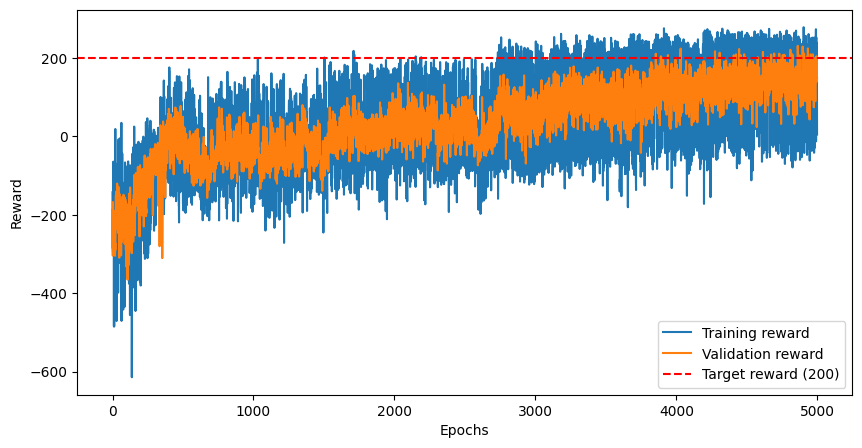

In [12]:
plot_rewards(num_epsiodes,train_rewards,test_rewards)

The convergence is so slow, and it took about 8 hours and 20 minutes- very slowly. Obviously this isn't the way. It made us think to add a scheduler to the code.<br>
<br>
We chose to use the scheduler StepLR because the training process is so unstable as we can see in the graphs, even in the evaluation graph.<br>
TD(0) with scheduler (stepLR with patience 300):

#### ${\color{cyan}{\text{TD(λ) with scheduler}}}$


In [ ]:
actor_learning_rate =  0.0005
critic_learning_rate = 0.001
num_epsiodes = 5000
gamma=0.995

actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

scheduler_actor = StepLR(optimizer_actor, step_size=300, gamma=0.95)
scheduler_critic = StepLR(optimizer_critic, step_size=300, gamma=0.95)

print(f"parameters: {sum(p.numel() for p in actor.parameters() if p.requires_grad)}")
print(f"parameters: {sum(p.numel() for p in critic.parameters() if p.requires_grad)}")

actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda(
    env,actor,critic,optimizer_actor,optimizer_critic,scheduler_actor,scheduler_critic,num_epsiodes,gamma,0.9,0.9)

# we will add scheduler
# 296m 44.7s

parameters: 1668
parameters: 1281


100%|██████████| 4999/4999 [4:56:44<00:00,  3.56s/it, val_reward=231]                                            


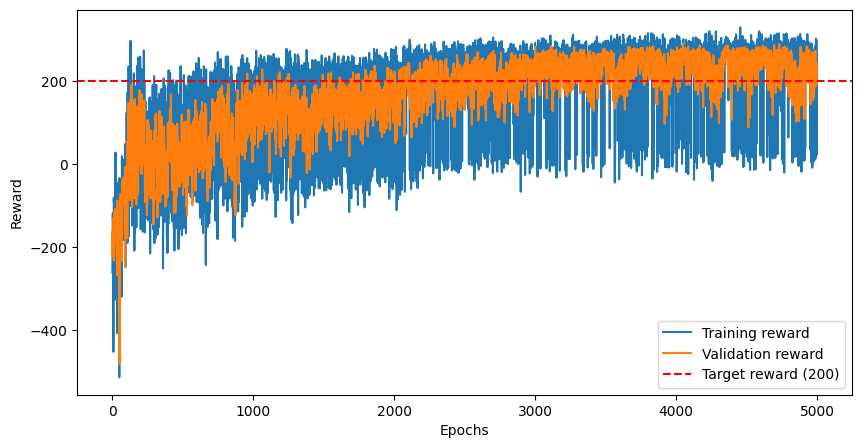

In [10]:
plot_rewards(num_epsiodes,train_rewards,test_rewards)

In [50]:
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
model = torch.load(r"model\הרצה עם scheduler lambda 0.9 0.9\first 5000\AC lambda reward 277.24 episode 3754(best).pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")
model = torch.load(r"model\הרצה עם scheduler lambda 0.9 0.9\first 5000\AC lambda reward 280.21 episode 4349(best).pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [03:38<00:00, 22.87it/s]


avarage reward is 267.74845263425516, the accuracy is 98.72%, (4936/5000)


100%|██████████| 5000/5000 [03:10<00:00, 26.19it/s]

avarage reward is 272.17369093925873, the accuracy is 98.34%, (4917/5000)


#### ${\color{cyan}{\text{TD(0) with scheduler stepLR stepsize=300}}}$


In [ ]:
actor_learning_rate =  0.0005
critic_learning_rate = 0.001
num_epsiodes = 5000
gamma=0.995

actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

scheduler_actor = StepLR(optimizer_actor, step_size=300, gamma=0.95)
scheduler_critic = StepLR(optimizer_critic, step_size=300, gamma=0.95)

actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array=train_TD_zero_v2(
    env,actor,critic,optimizer_actor,optimizer_critic,scheduler_actor,scheduler_critic,num_epsiodes,gamma)
#286m 2.2s

parameters: 1668
parameters: 1281


100%|██████████| 4999/4999 [4:46:02<00:00,  3.43s/it, total_val_reward=232]      


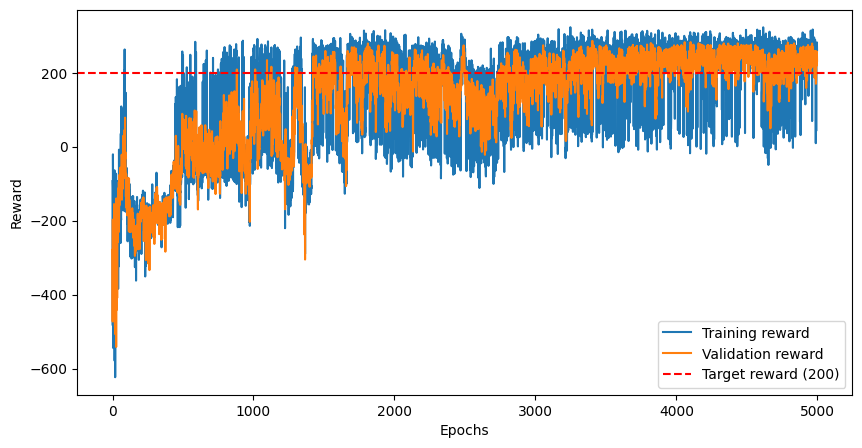

In [20]:
plot_rewards(num_epsiodes,train_rewards,test_rewards)

The best model was at episode 1888

In [42]:
model = torch.load(r"model\TD0 V2 with scheduler\AC reward 273.56 episode 1888.pt", weights_only=False)
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")


100%|██████████| 5000/5000 [03:55<00:00, 21.25it/s]

avarage reward is 258.3255824992446, the accuracy is 96.24000000000001%, (4812/5000)


#### ${\color{cyan}{\text{Let's try to do more episodes with TD(λ) with scheduler}}}$

We will take the last model of lambda 0.9 0.9 in the training that gave the best results, and continue training.
* another 15000
* total 20000

In [ ]:
actor_learning_rate =  0.0005
critic_learning_rate = 0.001
num_epsiodes = 15000
gamma=0.995
state_size=8
action_space_size=4
model = torch.load(r"model\הרצה עם scheduler lambda 0.9 0.9\first 5000\last AC lambda reward 230.15 episode 4999.pt", weights_only=False)  # or whatever episode
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

actor.load_state_dict(model['actor'])
critic.load_state_dict(model['critic'])
optimizer_actor.load_state_dict(model['optimizer_actor'])
optimizer_critic.load_state_dict(model['optimizer_critic'])

print(optimizer_actor.param_groups[0]["lr"])


scheduler_actor = StepLR(optimizer_actor, step_size=300, gamma=0.95)
scheduler_critic = StepLR(optimizer_critic, step_size=300, gamma=0.95)


actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards,test_rewards,time_array=train_TD_lambda(
    env,actor,critic,optimizer_actor,optimizer_critic,scheduler_actor,scheduler_critic,num_epsiodes,gamma,0.9,0.9)

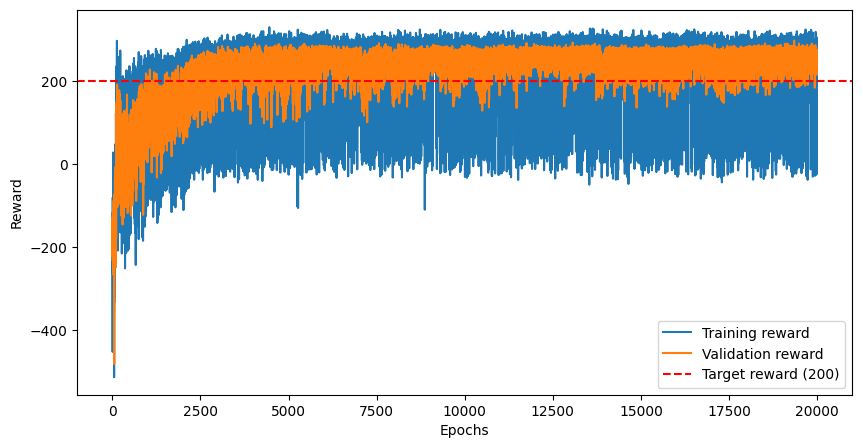

In [ ]:
plot_rewards(19997,train_rewards,test_rewards)

The best model was at episode 5883

In [13]:
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
model = torch.load(r"model\הרצה עם scheduler lambda 0.9 0.9\AC lambda reward 279.63 episode 5873 best.pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")
model = torch.load(r"model\הרצה עם scheduler lambda 0.9 0.9\AC lambda reward 286.49 episode 5883 best.pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")

100%|██████████| 5000/5000 [07:42<00:00, 10.80it/s]


avarage reward is 268.7324387985429, the accuracy is 98.6%, (4930/5000)


100%|██████████| 5000/5000 [05:14<00:00, 15.90it/s]

avarage reward is 269.9556843810908, the accuracy is 99.2%, (4960/5000)


#### ${\color{cyan}{\text{TD(λ) with more episodes}}}$

* Additional 5000

In [ ]:
actor_learning_rate =  0.0005
critic_learning_rate = 0.001
num_epsiodes = 2500
gamma=0.995
state_size=8
action_space_size=4
model = torch.load(r"model\lambda 0.9,0.9\second 2500\last AC lambda reward 275.05 episode 2499.pt", weights_only=False)  # or whatever episode
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)
train_rewards=model["train_rewards"]
test_rewards=model["test_rewards"]
actor.load_state_dict(model['actor'])
critic.load_state_dict(model['critic'])
optimizer_actor.load_state_dict(model['optimizer_actor'])
optimizer_critic.load_state_dict(model['optimizer_critic'])
actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array=train_TD_lambda(env,actor,critic,optimizer_actor,optimizer_critic,
    num_epsiodes=num_epsiodes,gamma=gamma,lambda_actor=0.9,lambda_critic=0.9,train_rewards=train_rewards,test_rewards=test_rewards,treshold=270)




100%|██████████| 2499/2499 [1:00:42<00:00,  1.46s/it, val_reward=284]


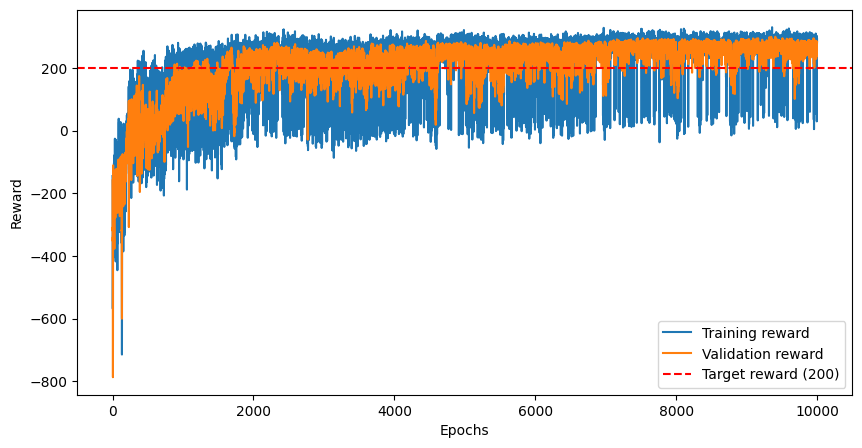

In [10]:
plot_rewards(9998,train_rewards,test_rewards)

The best model was at episode 9140

In [48]:
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)
model = torch.load(r"model\lambda 0.9,0.9\AC lambda reward 280.38 episode 9484(lambda0.9,0.9).pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")
model = torch.load(r"model\lambda 0.9,0.9\AC lambda reward 289.64 episode 9140(lambda0.9,0.9).pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")

100%|██████████| 5000/5000 [07:15<00:00, 11.48it/s]


avarage reward is 275.55936719917463, the accuracy is 99.06%, (4953/5000)


100%|██████████| 5000/5000 [03:50<00:00, 21.73it/s]

avarage reward is 278.3546874534307, the accuracy is 99.08%, (4954/5000)


### ${\color{cyan}{\text{TD(0) v2 - the best model}}}$

* 10000 episodes

In [ ]:
actor_learning_rate =  0.0005
critic_learning_rate = 0.001
num_epsiodes = 10000
gamma=0.995
state_size=8
action_space_size=4
actor = Actor(state_size,action_space_size)
critic = Critic(state_size)

optimizer_actor = optim.Adam(actor.parameters(), lr=actor_learning_rate)
optimizer_critic = optim.Adam(critic.parameters(), lr=critic_learning_rate)

actor,critic, optimizer_actor,optimizer_critic, episode, train_rewards, test_rewards,time_array=train_TD_zero_v2(env,actor,critic,optimizer_actor,optimizer_critic,num_epsiodes=num_epsiodes,gamma=gamma,treshold=268)

#418m 28s

100%|██████████| 9999/9999 [6:58:27<00:00,  2.51s/it, val_reward=152]     


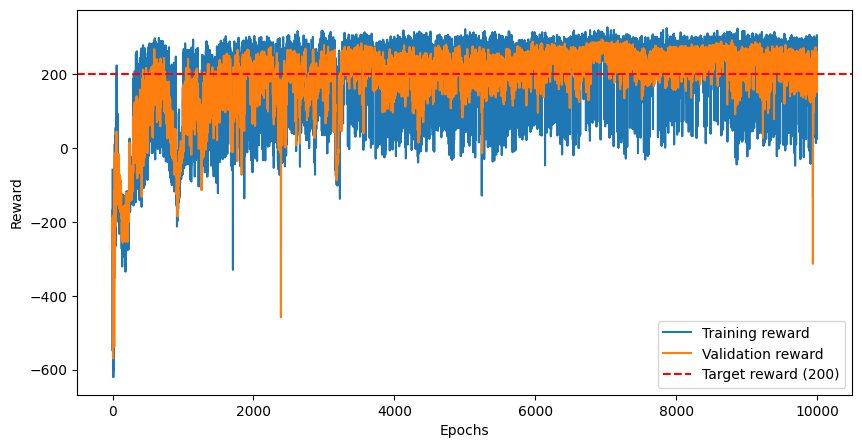

In [40]:
plot_rewards(10000,train_rewards,test_rewards)

Our actor critic best model was in this try, at episode 6235

In [ ]:
number_of_val_epochs=5000
actor = Actor(state_size,action_space_size)

model = torch.load(r"model\TD0V210000 Episodes\AC reward 280.55 episode 6235.pt", weights_only=False)
actor.load_state_dict(model['actor'])
total_reward,accuracy =test_model(actor,number_of_val_epochs,None,True)
print(f"avarage reward is {total_reward}, the accuracy is {np.round(accuracy/number_of_val_epochs,4)*100}%, ({accuracy}/{number_of_val_epochs})")

100%|██████████| 5000/5000 [04:38<00:00, 17.96it/s]

avarage reward is 268.91776783894875, the accuracy is 99.98%, (4999/5000)


### ${\color{cyan}{\text{The best AC model:}}}$

This is the best model of AC.\
We got it after 6235 episodes, it took 5 hours, 5 minutes and 56.57 seconds

----------------

# ${\color{lime}{\text{Comaprison}}}$


After we got all the models and results, LET US COMPARE:  
The best **Deep-Q-Network** model was after 3107 episodes which took 38 minutes to train,  
while the best **Actor-Critic** model was after 6235 episodes which took 5 hours and 6 minutes to train. 
  
The models with the highest average rewards were:  
Double-DQN model which we got after 1631 episodes which took 20 minutes.\
Actor Critic TD($\lambda$) which we got after 9140 episodes which took 6 hours and 20 minutes.

The results:  
**DQN** - Average rewards: 271.4 , Accuracy : 4999/5000 (99.98 \%)  
**AC** - Average rewards: 268.9 , Accuracy : 4999/5000 (99.98 \%)  
**DDQN** - Average rewards: 276.1 , Accuracy : 4942/5000 (98.84 \%)  
**AC TD($\lambda$)** - Average rewards: 278.35 , Accuracy : 4954/5000 (99.08 \%)

We managed to get the same accuracy with both DQN and AC but DQN has a better average reward and took less training.  
And we have models that have a higher average but lower accuracy than our best models (99.98 \% success).
  
If we trained DQN (and DDQN) as much as we trained AC maybe the average rewards would have been higher but since we got a very good model so fast we didn't think it is necessarily.  

DQN has more parameters (DQN - 4996  , Actor - 1668  , Critic - 1281 ) which might be one of the reasons it learns in fewer episodes.

| **Algorithm**           | **Training Episodes** | **Training Time (until the model's episode)**      | **Average rewards** | **Accuracy (out of 5000)** |
|-------------------------|--------------|----------------------|--------------|--------------|
| Deep Q Network          | 3107         | 38 minutes      | 271.4                | 99.98%       |
| Actor Critic TD(0)      | 6235         | 5 hours and 6 minutes      | 268.9                | 99.98%       |
| Actor Critic TD($\lambda$) | 9140     | 6 hours and 20 minutes       | 278.35               | 99.08%       |
| Double DQN              | 1631         | 20 minutes       | 276.1                | 98.84%       |


We consider the accuracy and the training time as the most important factors, which is why we think that DQN is better in this environment.
We tried to find 2 models that have the same great accuracy, and by that to compare the time, we see that to get the same results as the DQN, the Actor Critic had to do **twice the amount** of episodes and **8 times** the amount of running time running time, not to mention that we got the best model for DQN quite fast without needing to adjust it by a lot, in comparison to the AC that took us a huge amount of work to achieve the same accuracy.<br>
<br>
Another way to choose the model is by stability criteria. The accuracy is 4999 out of 5000 meaning that the results are quite stable about 200 reward. <br>
Furthermore, when we look at the graphs we can see that learning process is almost the same, in the beginning we go up until we are almost all the time above the 200 reward line, but and this is a big but the DQN is more stable than the AC, it has less places that validation reward goes beneath 200 reward, and more places in which the graph is always above that line without any interruptions.


# ${\color{lime}{\text{Future Work}}}$
In the future, we would like to examine more complicated variation of DQN and AC, the versions that we used are the basic ones, and by now there are more complex and refined methods of doing that.\
In addition to really compare the difference between the two algorithms we need to check other environments, maybe this one is more suited to DQN and another one might be for AC.\
Furthermore, we would like to explore more ways to reduce the running time, especially in AC which take a lot of time to train.\
To end with, we would like to explore more ways to make the graphs more stable (we tried to do that in the hyper parameters tuning but there might be another way we didn't think about like a more advanced model). 

# ${\color{lime}{\text{Conclusion}}}$


In this project we saw a comparison between 2 RL algorithms- Actor Critic and Deep Q Network.\
We learned the theoretical material of Actor-Critic and Deep Q-Network, we learned how they work and we saw how they performed on the Lunar Lander environment.\
We saw how hyperparameters affect the results and we many different models.  

We got the code for each algorithm and a lot of graphs :)
We learned about the mistakes we had at the beginning that caused problems in the learning process. 
We understood how we choose the best model in the training, and saw other possible ways to choose.
We looked at comparison criteria such as accuracy, running time, stability and average reward to examine how our best model behaves and choose which algorithm is the superior one.
After checking all the models and looking for the best accuracy we got the best models of the DQN and AC:  
Both with accuracy of 99.98 \% but the DQN model had a higher average reward(271.4 average rewards for DQN and 268.9 average rewards for AC), and the significant difference between them is that the DQN model took a lot less time than the Actor Critic to receive the same results, 38 minutes against 5 hours.\

DQN gave us very good results that took much less episodes and less training time than AC which is why we think DQN is better for Lunar Lander. 


# ${\color{lime}{\text{Bibliography}}}$


(1) [https://gymnasium.farama.org/environments/box2d/lunar_lander/](Lunar Lender Description) 

(2) [https://www.geeksforgeeks.org/deep-learning/deep-q-learning/]
(Geeks for Geeks - DQN) 

(3) [https://medium.com/data-science/math-of-q-learning-python-code-5dcbdc49b6f6]
(Medium: Math of Q-learning)

(4) [https://apxml.com/courses/intermediate-reinforcement-learning/chapter-3-dqn-improvements-variants/double-dqn-ddqn](Apx: machine learning (Double DQN)) 

(5) The lecturer Idan Tobis's lecture notes 

(6) [https://www.geeksforgeeks.org/machine-learning/actor-critic-algorithm-in-reinforcement-learning/](Actor Critic Geeks for Geeks)  

(7) [https://en.wikipedia.org/wiki/Actor-critic_algorithm](Actor Critic Wikipedia) 

(8) [https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae]
(Medium : DQN some example) 

(9)[https://shiva-verma.medium.com/solving-lunar-lander-openaigym-reinforcement-learning-785675066197]
(Picture for Introduction (Lunar Lander)) 